# Trade War Networks — Single Notebook Pipeline

A compact, **four-part** end-to-end pipeline in one notebook:

1. **Data Collection** — UN Comtrade (trade flows), World Bank/IMF indicators *(optional API calls)*.
2. **Global Trade Network Analysis** — Build yearly trade graphs, compute centrality & modularity.
3. **Time Series & Breakpoint Detection** — ARIMA forecasting & change-point detection.
4. **Environmental Impact Estimation** — Shipping route distances and CO₂ estimates.

## 0) Setup & Config

In [1]:
%pip install ruptures --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00


In [2]:
# Optional installs (uncomment in Colab or first run locally)
# !pip install pandas numpy networkx plotly statsmodels ruptures geopy

import os, json, time, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
import ruptures as rpt

warnings.filterwarnings('ignore')

# --- Paths ---
BASE = Path('.')
DATA_RAW = BASE / 'data' / 'raw'
DATA_PROC = BASE / 'data' / 'processed'
FIGURES = BASE / 'figures'
REPORTS = BASE / 'reports'
for p in (DATA_RAW, DATA_PROC, FIGURES, REPORTS):
    p.mkdir(parents=True, exist_ok=True)

# --- Config ---
config = {
    'years': list(range(2015, 2023)),
    'focus_countries': ['USA', 'CHN', 'VNM', 'MEX'],  # ISO3 preferred for consistency
    'hs_sections': ['84', '85'],  # Electronics (HS84/85) as example
    'use_api_calls': True,       # If False → run with synthetic data only
    'comtrade_api_base': 'https://comtrade.un.org/api/get',
    'world_bank_indicators': ['NE.TRD.GNFS.ZS'],  # Trade (% of GDP) example
    'marine_emission_factor_g_per_tkm': 10.0      # rough placeholder
}
with open(DATA_PROC / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)
PARTNER_MODE = "focus"

def _ensure_parent(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)

def _sleep_throttle(seconds: float = 1.2):
    time.sleep(seconds)

print('✅ Setup complete.')

✅ Setup complete.


## 1) Data Collection

In [26]:
%pip install comtradeapicall --quiet

import comtradeapicall

In [61]:
# =========================
# 1) CONFIG & FOLDERS
# =========================
import os, json, time, warnings, re, random, shutil, datetime as dt
from pathlib import Path
from typing import List, Optional
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# Project folders (idempotent)
BASE = Path('.')
DATA_RAW  = BASE / 'data' / 'raw'
DATA_PROC = BASE / 'data' / 'processed'
FIGURES   = BASE / 'figures'
REPORTS   = BASE / 'reports'
for p in (DATA_RAW, DATA_PROC, FIGURES, REPORTS):
    p.mkdir(parents=True, exist_ok=True)

# Scope (tweak as needed)
config = {
    "years": list(range(2015, 2023)),                 # time span
    "focus_countries": ["USA", "CHN", "VNM", "MEX",
                        "DEU","JPN","KOR","CAN","TWN","THA","MYS"],  # richer network
    "hs_sections": ["84", "85"],                      # electronics (HS2)
    "use_api_calls": True,                            # True → use Comtrade preview API
    "preview_max_records": 500,                       # per preview call cap (Preview API)
    "sleep_between_calls": 1.2,                       # polite throttle between calls (seconds)

    # Quota-aware behavior:
    "respect_quota_sleep": True,      # True = automatically sleep and resume when 403 quota appears
    "quota_sleep_ceiling_min": 30,    # safety ceiling in minutes (cap the sleep to avoid excessive waits)

    # World Bank indicators to fetch (macro context)
    "wb_indicators": [
        "NE.TRD.GNFS.ZS",   # Trade (% of GDP)
        "NY.GDP.MKTP.CD",   # GDP (current US$)
        "NY.GDP.MKTP.KD",   # GDP (constant)
        "FP.CPI.TOTL"       # CPI
    ]
}
# Partner expansion mode for Comtrade:
# "focus" → partners = focus_countries (full matrix within the set)
# "world" → partners = ["WLD"] (aggregate flows vs World)
PARTNER_MODE = "focus"

# ISO3 → UN M49 numeric (extend if you add more countries)
COUNTRY_ISO3_TO_CODE = {
    "USA": 842, "CHN": 156, "VNM": 704, "MEX": 484,
    "DEU": 276, "JPN": 392, "KOR": 410, "CAN": 124,
    "TWN": 490, "THA": 764, "MYS": 458,
    "WLD": 0    # World aggregate
}

# Save config (idempotent overwrite)
with open(DATA_PROC / 'config.json', 'w') as f:
    json.dump({**config, "PARTNER_MODE": PARTNER_MODE}, f, indent=2)

print("✅ Config & folders are ready.")

✅ Config & folders are ready.


In [62]:
# =========================
# 2) UTILITIES & SYNTHETIC
# =========================
def _sleep(seconds: Optional[float] = None):
    """Polite throttle between preview calls."""
    time.sleep(seconds if seconds is not None else config["sleep_between_calls"])

def _ensure_parent(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)

def iso3_to_m49(iso3: str) -> int:
    """Convert ISO3 to UN M49 numeric code (raises if missing)."""
    iso3 = iso3.upper()
    if iso3 not in COUNTRY_ISO3_TO_CODE:
        raise ValueError(f"Missing ISO3→M49 mapping for '{iso3}'")
    return int(COUNTRY_ISO3_TO_CODE[iso3])

def synthetic_trade_data(years, countries):
    """
    Minimal synthetic bilateral dataset (used only if use_api_calls=False).
    Schema: year, reporter, partner, hs2, flow, trade_value_usd
    """
    rng = np.random.default_rng(42)
    rows = []
    for y in years:
        for r in countries:
            for p in countries:
                if r == p:
                    continue
                base = 1e9 if {r, p} == {'USA', 'CHN'} else 2e8
                shock = 0.7 if (y >= 2018 and {r,p}=={'USA','CHN'}) else 1.0
                val = base * shock * (1 + 0.05*(y - min(years))) * rng.normal(1.0, 0.05)
                rows.append((y, r, p, "ALL", "ALL", max(val, 0.0)))
    return pd.DataFrame(rows, columns=['year','reporter','partner','hs2','flow','trade_value_usd'])

In [63]:
# =========================
# 3) COMTRADE PREVIEW (QUOTA-AWARE + CHUNK CACHE)
# =========================
import comtradeapicall  # pip install comtradeapicall
import io, contextlib

# ---- Helpers for normalizing API outputs ----
def _pick(raw: pd.DataFrame, choices):
    """Return first existing column among choices; else Series of Nones."""
    for c in choices:
        if c in raw.columns:
            return raw[c]
    return pd.Series([None] * len(raw))

def _to_year(series, fallback_year: int):
    y = pd.to_numeric(series, errors="coerce")
    if isinstance(y, pd.Series):
        y = y.fillna(fallback_year).astype(int)
    else:
        y = int(fallback_year)
    return y

# ---- Quota parsing ----
def _parse_quota_seconds(msg: str) -> int:
    """
    Extract seconds from messages like:
    'Out of call volume quota. Quota will be replenished in 00:20:33.'
    """
    m = re.search(r"(\d{2}):(\d{2}):(\d{2})", msg or "")
    if not m:
        return 60  # default backoff if unexpected format
    h, m_, s = map(int, m.groups())
    return h*3600 + m_*60 + s

# --- Patch: quota-aware even when the library only PRINTS the 403 message ---
def _call_preview(year: int, reporter_iso3: str, partner_iso3: str, hs2: str):
    """
    Low-level call to comtradeapicall.previewFinalData with quota-aware retry.
    Handles three cases:
      (a) library RETURNS a dict with statusCode=403
      (b) library RAISES an exception containing the quota text
      (c) library only PRINTS the 403 message to stdout (no raise/return)
    In all cases we parse the HH:MM:SS and sleep before retrying.
    """
    r_code = str(iso3_to_m49(reporter_iso3))
    p_code = '0' if partner_iso3 == "WLD" else str(iso3_to_m49(partner_iso3))

    attempts = 0
    while True:
        printed = ""
        try:
            buf = io.StringIO()
            with contextlib.redirect_stdout(buf):
                res = comtradeapicall.previewFinalData(
                    typeCode='C', freqCode='A', clCode='HS', period=str(year),
                    reporterCode=r_code, partnerCode=p_code,
                    partner2Code=None, customsCode=None, motCode=None,
                    cmdCode=str(hs2), flowCode='X,M',
                    maxRecords=int(config["preview_max_records"]), format_output='JSON',
                    aggregateBy=None, breakdownMode='classic',
                    countOnly=None, includeDesc=True
                )
            printed = buf.getvalue()

            # Case (c): quota message was only printed
            if "Out of call volume quota" in printed:
                sec = _parse_quota_seconds(printed)
                sec = min(sec, int(config["quota_sleep_ceiling_min"]*60)) + random.randint(3,9)
                print(f"⏳ Quota hit (printed): sleeping {sec} seconds (y={year}, {reporter_iso3}->{partner_iso3}, hs2={hs2})")
                if config["respect_quota_sleep"]:
                    time.sleep(sec)
                    continue
                else:
                    return None

            # Case (a): a dict payload that explicitly signals 403
            if isinstance(res, dict) and res.get('statusCode') == 403:
                msg = res.get('message', '')
                sec = _parse_quota_seconds(msg)
                sec = min(sec, int(config["quota_sleep_ceiling_min"]*60)) + random.randint(3,9)
                print(f"⏳ Quota hit: sleeping {sec} seconds (y={year}, {reporter_iso3}->{partner_iso3}, hs2={hs2})")
                if config["respect_quota_sleep"]:
                    time.sleep(sec)
                    continue
                else:
                    return None

            return res  # success

        except Exception as e:
            # Case (b): quota in the exception text
            msg = printed + "\n" + str(e)
            if "Out of call volume quota" in msg:
                sec = _parse_quota_seconds(msg)
                sec = min(sec, int(config["quota_sleep_ceiling_min"]*60)) + random.randint(3,9)
                print(f"⏳ Quota hit (exception): sleeping {sec} seconds (y={year}, {reporter_iso3}->{partner_iso3}, hs2={hs2})")
                if config["respect_quota_sleep"]:
                    time.sleep(sec)
                    continue
                else:
                    return None

            # Non-quota errors → bounded retries with exponential backoff
            attempts += 1
            wait = min(2**attempts, 32) + random.random()
            print(f"⚠️ Preview error (attempt {attempts}): {e} | backoff {wait:.1f}s")
            time.sleep(wait)
            if attempts >= 5:
                print("⛔ Giving up this chunk after repeated errors.")
                return None

# ---- Normalize any returned object to the canonical DataFrame schema ----
def _normalize_res_to_df(res, fallback_year: int) -> pd.DataFrame:
    """
    Map API result (dict or DataFrame) to our schema:
    [year, reporter, partner, hs2, flow, trade_value_usd]
    """
    if res is None:
        return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])

    if isinstance(res, pd.DataFrame):
        raw = res.copy()
    elif isinstance(res, dict):
        # normal successful payload is dict with 'data' list
        if res.get('statusCode') and res.get('statusCode') != 200 and 'data' not in res:
            # not a data payload (quota or other msg)
            return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])
        data = res.get('data', [])
        if not isinstance(data, list) or len(data) == 0:
            # legitimate "no data" case
            return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])
        raw = pd.DataFrame(data)
    else:
        return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])

    if raw.empty:
        return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])

    period      = _pick(raw, ['period', 'refYear'])
    reporterISO = _pick(raw, ['reporterISO', 'rt3ISO'])
    partnerISO  = _pick(raw, ['partnerISO',  'pt3ISO'])
    cmd         = _pick(raw, ['cmdCode', 'commodityCode'])
    flowCode    = _pick(raw, ['flowCode'])
    primaryVal  = _pick(raw, ['primaryValue', 'primaryvalue'])

    out = pd.DataFrame({
        'year' : _to_year(period, fallback_year),
        'reporter': reporterISO.astype(str),
        'partner' : partnerISO.astype(str),
        'hs2'     : cmd.astype(str).str[:2],
        'flow'    : np.where(flowCode.astype(str).str.upper().eq('X'), 'export', 'import'),
        'trade_value_usd': pd.to_numeric(primaryVal, errors='coerce').fillna(0.0).astype(float)
    })
    out = out[(out['reporter'].notna()) & (out['partner'].notna()) & (out['reporter'] != out['partner'])]
    return out.reset_index(drop=True)

# ---- Chunk path & logic ----
def _chunk_path(year: int, r_iso: str, p_iso: str, hs2: str) -> Path:
    key = f"y{year}_{r_iso}_{p_iso}_{hs2}"
    return DATA_RAW / "chunks" / f"comtrade_preview_{key}.parquet"

def _fetch_chunk(year: int, r_iso: str, p_iso: str, hs2: str) -> pd.DataFrame:
    """
    Fetch one (year, reporter, partner, hs2) chunk with quota-aware retry.
    Writes the chunk ONLY after a successful API call (even if empty legit data).
    """
    DATA_RAW.joinpath("chunks").mkdir(parents=True, exist_ok=True)
    cpath = _chunk_path(year, r_iso, p_iso, hs2)

    # If chunk already exists, use it (idempotent resume).
    if cpath.exists():
        try:
            return pd.read_parquet(cpath)
        except Exception:
            pass  # re-fetch if file is corrupted

    # Call API (quota-aware) and normalize
    res = _call_preview(year, r_iso, p_iso, hs2)
    df  = _normalize_res_to_df(res, fallback_year=year)

    # Save (also save empty legit result to avoid re-hammering forever)
    _ensure_parent(cpath)
    if df is None or df.empty:
        # write empty with schema to mark "done (no data)"
        pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd']).to_parquet(cpath, index=False)
    else:
        df.to_parquet(cpath, index=False)
    return df

# ---- Assemble a full year from chunks ----
def fetch_comtrade_preview_year(year: int,
                                reporters_iso3: List[str],
                                partners_iso3: List[str],
                                hs2_list: List[str]) -> pd.DataFrame:
    chunks = []
    for r in reporters_iso3:
        for p in partners_iso3:
            if p != "WLD" and r == p:
                continue
            for hs2 in hs2_list:
                print(f"↳ Fetching chunk y={year} {r}->{p} hs2={hs2} ...")
                df = _fetch_chunk(year, r, p, hs2)
                if df is not None and not df.empty:
                    chunks.append(df)
                _sleep()  # politeness
    if chunks:
        year_df = pd.concat(chunks, ignore_index=True)
        year_df = year_df.drop_duplicates(subset=['year','reporter','partner','hs2','flow'], keep='last')
    else:
        year_df = pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])

    # Keep an assembled per-year cache too
    rkey = "-".join(sorted(set(reporters_iso3)))
    pkey = "-".join(sorted(set(partners_iso3)))
    assembled_path = DATA_RAW / f"comtrade_preview_{year}_{rkey}_{pkey}.parquet"
    year_df.to_parquet(assembled_path, index=False)
    return year_df

# ---- Orchestrate multi-year collection ----
def collect_comtrade_preview(years: List[int],
                             reporters_iso3: List[str],
                             partner_mode: str,
                             hs2_list: List[str]) -> pd.DataFrame:
    partners_iso3 = (reporters_iso3 if partner_mode == "focus" else ["WLD"])
    all_years = []
    for y in years:
        print(f"⏳ Fetching Comtrade preview for year {y} (partners={partner_mode}) ...")
        ydf = fetch_comtrade_preview_year(y, reporters_iso3, partners_iso3, hs2_list)
        all_years.append(ydf)
    if not all_years:
        return pd.DataFrame(columns=['year','reporter','partner','hs2','flow','trade_value_usd'])
    df = pd.concat(all_years, ignore_index=True)
    df = df.drop_duplicates(subset=['year','reporter','partner','hs2','flow'], keep='last')
    return df

In [64]:
# =========================
# 4) WORLD BANK INDICATORS
# =========================
import requests

def world_bank_fetch(indicator: str, iso3_list, start_year: int, end_year: int) -> pd.DataFrame:
    """
    Fetch World Bank indicator for multiple countries over a year range.
    Returns: country (ISO3), year, indicator, value
    """
    if not iso3_list:
        return pd.DataFrame(columns=['country','year','indicator','value'])

    iso3_str = ";".join([c.lower() for c in iso3_list])
    url = f"https://api.worldbank.org/v2/country/{iso3_str}/indicator/{indicator}"
    params = {"date": f"{start_year}:{end_year}", "format": "json", "per_page": "20000"}

    try:
        r = requests.get(url, params=params, timeout=60)
        r.raise_for_status()
        data = r.json()
    except Exception as e:
        print(f"⚠️ World Bank fetch failed for {indicator}: {e}")
        return pd.DataFrame(columns=['country','year','indicator','value'])

    if not data or len(data) < 2 or not isinstance(data[1], list):
        return pd.DataFrame(columns=['country','year','indicator','value'])

    rows = []
    for rec in data[1]:
        c = (rec.get("countryiso3code") or "").upper()
        yr = rec.get("date")
        val = rec.get("value")
        if not c or yr is None:
            continue
        try:
            rows.append((c, int(yr), indicator, float(val) if val is not None else np.nan))
        except:
            pass
    return pd.DataFrame(rows, columns=['country','year','indicator','value'])

In [65]:
# Delete empty chunk files so they will be retried
from pathlib import Path
import pandas as pd

chunk_dir = DATA_RAW / "chunks"
if chunk_dir.exists():
    removed = 0
    for f in chunk_dir.glob("comtrade_preview_*.parquet"):
        try:
            df = pd.read_parquet(f)
            if df is None or df.empty:
                f.unlink()
                removed += 1
        except Exception:
            # corrupted file? remove it too
            f.unlink()
            removed += 1
    print(f"🧹 Removed {removed} empty/corrupted chunk files.")
else:
    print("No chunk directory yet; nothing to clean.")

🧹 Removed 320 empty/corrupted chunk files.


In [66]:
# =========================
# 5) RUN COLLECTION & SAVE
# =========================

# 5.1 Trade (Comtrade preview OR synthetic)
if config["use_api_calls"]:
    trade_df = collect_comtrade_preview(
        years=config["years"],
        reporters_iso3=config["focus_countries"],
        partner_mode=PARTNER_MODE,      # "focus" or "world"
        hs2_list=config["hs_sections"]
    )
else:
    trade_df = synthetic_trade_data(config["years"], config["focus_countries"])

# Save canonical bilateral-by-HS2 table (overwrite idempotently)
trade_path = DATA_PROC / "trade_bilateral_by_hs2.parquet"
trade_df.to_parquet(trade_path, index=False)

print("Trade sample:")
display(trade_df.head(10))

# 5.2 World Bank indicators
wb_dfs = []
for ind in config["wb_indicators"]:
    print(f"⏳ Fetching World Bank indicator: {ind}")
    wb_dfs.append(world_bank_fetch(ind, config["focus_countries"],
                                   start_year=min(config["years"]),
                                   end_year=max(config["years"])))
wb_df = (pd.concat(wb_dfs, ignore_index=True) if len(wb_dfs) else
         pd.DataFrame(columns=['country','year','indicator','value']))
wb_path = DATA_PROC / "world_bank_indicators.parquet"
wb_df.to_parquet(wb_path, index=False)

print("World Bank sample:")
display(wb_df.head(10))

# 5.3 Derived artifacts for next parts
# (A) Network-ready edges per year (exports/imports as weights)
trade_net = (trade_df
             .groupby(['year','reporter','partner','flow'], as_index=False)['trade_value_usd']
             .sum())
trade_net_path = DATA_PROC / "trade_network_ready.parquet"
trade_net.to_parquet(trade_net_path, index=False)

# (B) Country totals per year (exports/imports)
exp_ts = (trade_df[trade_df['flow']=='export']
          .groupby(['year','reporter'], as_index=False)['trade_value_usd'].sum()
          .rename(columns={'reporter':'country','trade_value_usd':'exports'}))
imp_ts = (trade_df[trade_df['flow']=='import']
          .groupby(['year','partner'], as_index=False)['trade_value_usd'].sum()
          .rename(columns={'partner':'country','trade_value_usd':'imports'}))
ts_df = (pd.merge(exp_ts, imp_ts, on=['year','country'], how='outer')
         .fillna(0.0).sort_values(['country','year']))
ts_path = DATA_PROC / "country_totals_ts.parquet"
ts_df.to_parquet(ts_path, index=False)

# (C) HS2 totals (sectoral time series)
hs2_ts = (trade_df.groupby(['year','flow','hs2'], as_index=False)['trade_value_usd'].sum())
hs2_ts_path = DATA_PROC / "hs2_totals_ts.parquet"
hs2_ts.to_parquet(hs2_ts_path, index=False)

print("✅ Saved:")
print(" -", trade_path)
print(" -", trade_net_path)
print(" -", ts_path)
print(" -", hs2_ts_path)
if len(wb_df):
    print(" -", wb_path)

⏳ Fetching Comtrade preview for year 2015 (partners=focus) ...
↳ Fetching chunk y=2015 USA->CHN hs2=84 ...
↳ Fetching chunk y=2015 USA->CHN hs2=85 ...
↳ Fetching chunk y=2015 USA->VNM hs2=84 ...
↳ Fetching chunk y=2015 USA->VNM hs2=85 ...
↳ Fetching chunk y=2015 USA->MEX hs2=84 ...
↳ Fetching chunk y=2015 USA->MEX hs2=85 ...
↳ Fetching chunk y=2015 USA->DEU hs2=84 ...
↳ Fetching chunk y=2015 USA->DEU hs2=85 ...
↳ Fetching chunk y=2015 USA->JPN hs2=84 ...
↳ Fetching chunk y=2015 USA->JPN hs2=85 ...
↳ Fetching chunk y=2015 USA->KOR hs2=84 ...
↳ Fetching chunk y=2015 USA->KOR hs2=85 ...
↳ Fetching chunk y=2015 USA->CAN hs2=84 ...
↳ Fetching chunk y=2015 USA->CAN hs2=85 ...
↳ Fetching chunk y=2015 USA->TWN hs2=84 ...
↳ Fetching chunk y=2015 USA->TWN hs2=85 ...
↳ Fetching chunk y=2015 USA->THA hs2=84 ...
↳ Fetching chunk y=2015 USA->THA hs2=85 ...
↳ Fetching chunk y=2015 USA->MYS hs2=84 ...
↳ Fetching chunk y=2015 USA->MYS hs2=85 ...
↳ Fetching chunk y=2015 CHN->USA hs2=84 ...
↳ Fetching ch

,year,reporter,partner,hs2,flow,trade_value_usd
0,2015,USA,CHN,84,import,1.070321e+11
1,2015,USA,CHN,84,export,1.224813e+10
2,2015,USA,CHN,85,import,1.360062e+11
3,2015,USA,CHN,85,export,1.276067e+10
4,2015,USA,VNM,84,import,2.604794e+09
5,2015,USA,VNM,84,export,6.001963e+08
6,2015,USA,VNM,85,import,8.382929e+09
7,2015,USA,VNM,85,export,8.650821e+08
8,2015,USA,MEX,84,import,4.927002e+10
9,2015,USA,MEX,84,export,4.206951e+10


⏳ Fetching World Bank indicator: NE.TRD.GNFS.ZS
⏳ Fetching World Bank indicator: NY.GDP.MKTP.CD
⏳ Fetching World Bank indicator: NY.GDP.MKTP.KD
⏳ Fetching World Bank indicator: FP.CPI.TOTL
World Bank sample:


,country,year,indicator,value
0,CAN,2022,NE.TRD.GNFS.ZS,67.317622
1,CAN,2021,NE.TRD.GNFS.ZS,62.246837
2,CAN,2020,NE.TRD.GNFS.ZS,61.156771
3,CAN,2019,NE.TRD.GNFS.ZS,66.171485
4,CAN,2018,NE.TRD.GNFS.ZS,66.599886
5,CAN,2017,NE.TRD.GNFS.ZS,65.101061
6,CAN,2016,NE.TRD.GNFS.ZS,65.363685
7,CAN,2015,NE.TRD.GNFS.ZS,66.164902
8,CHN,2022,NE.TRD.GNFS.ZS,37.440720
9,CHN,2021,NE.TRD.GNFS.ZS,36.520691


✅ Saved:
 - data/processed/trade_bilateral_by_hs2.parquet
 - data/processed/trade_network_ready.parquet
 - data/processed/country_totals_ts.parquet
 - data/processed/hs2_totals_ts.parquet
 - data/processed/world_bank_indicators.parquet


In [67]:
# =========================
# 6) QUICK AUDIT
# =========================
trade_path = DATA_PROC / "trade_bilateral_by_hs2.parquet"
if trade_path.exists():
    trade = pd.read_parquet(trade_path)
    print(f"ROWS: {len(trade):,}")
    print("Years coverage:")
    display(trade.groupby('year').size().rename('rows').reset_index())
    print("\nTop reporter→partner pairs by rows:")
    display(trade.groupby(['reporter','partner']).size().rename('rows').reset_index()
                  .sort_values('rows', ascending=False).head(12))
else:
    print("No processed trade file yet.")

ROWS: 3,520
Years coverage:


,year,rows
0,2015,440
1,2016,440
2,2017,440
3,2018,440
4,2019,440
5,2020,440
6,2021,440
7,2022,440



Top reporter→partner pairs by rows:


,reporter,partner,rows
0,CAN,CHN,32
1,CAN,DEU,32
2,CAN,JPN,32
3,CAN,KOR,32
4,CAN,MEX,32
5,CAN,MYS,32
6,CAN,S19,32
7,CAN,THA,32
8,CAN,USA,32
9,CAN,VNM,32


In [68]:
# =========================
# 7) SAVE TO GOOGLE DRIVE (TradeWar)
# =========================
# Will create/overwrite TradeWar/latest, and also add a timestamped snapshot.
try:
    from google.colab import drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

PROJECT_ROOT_NAME = "TradeWar"
TIMESTAMP = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)

    DRIVE_BASE   = Path("/content/drive/MyDrive") / PROJECT_ROOT_NAME
    LATEST_DIR   = DRIVE_BASE / "latest"
    SNAPSHOT_DIR = DRIVE_BASE / "snapshots" / f"snapshot_{TIMESTAMP}"

    # Re-create 'latest' cleanly (overwrite-safe)
    if LATEST_DIR.exists():
        shutil.rmtree(LATEST_DIR)
    for sub in ["data/raw", "data/processed", "figures", "reports"]:
        (LATEST_DIR / sub).mkdir(parents=True, exist_ok=True)

    def _copy_tree(src: Path, dst_root: Path):
        for p in src.rglob("*"):
            if p.is_file():
                rel = p.relative_to(BASE)
                outp = dst_root / rel
                outp.parent.mkdir(parents=True, exist_ok=True)
                shutil.copy2(p, outp)

    # Copy into 'latest'
    _copy_tree(DATA_RAW,   LATEST_DIR)
    _copy_tree(DATA_PROC,  LATEST_DIR)
    _copy_tree(FIGURES,    LATEST_DIR)
    _copy_tree(REPORTS,    LATEST_DIR)

    # Create a timestamped snapshot as well (append-only)
    for sub in ["data/raw", "data/processed", "figures", "reports"]:
        (SNAPSHOT_DIR / sub).mkdir(parents=True, exist_ok=True)
    _copy_tree(DATA_RAW,   SNAPSHOT_DIR)
    _copy_tree(DATA_PROC,  SNAPSHOT_DIR)
    _copy_tree(FIGURES,    SNAPSHOT_DIR)
    _copy_tree(REPORTS,    SNAPSHOT_DIR)

    # Write manifests
    manifest = {
        "created": TIMESTAMP,
        "config": config,
        "partner_mode": PARTNER_MODE,
        "files_raw":      [str(p.relative_to(BASE)) for p in DATA_RAW.rglob("*") if p.is_file()],
        "files_processed":[str(p.relative_to(BASE)) for p in DATA_PROC.rglob("*") if p.is_file()],
    }
    for target in [LATEST_DIR, SNAPSHOT_DIR]:
        with open(target / "manifest.json", "w") as f:
            json.dump(manifest, f, indent=2)

    print(f"✅ Saved to Drive:\n  - Latest:   {LATEST_DIR}\n  - Snapshot: {SNAPSHOT_DIR}")
else:
    print("ℹ️ Not running in Colab; Drive save skipped (use ZIP snapshot instead if needed).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved to Drive:
  - Latest:   /content/drive/MyDrive/TradeWar/latest
  - Snapshot: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_190639


In [69]:
# =========================
# 8) OPTIONAL: LOCAL ZIP SNAPSHOT
# =========================
import zipfile
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_path = BASE / f"TradeWar_data_snapshot_{ts}.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for folder in [DATA_RAW, DATA_PROC, FIGURES, REPORTS]:
        for path in folder.rglob("*"):
            if path.is_file():
                z.write(path, arcname=str(path.relative_to(BASE)))
print(f"📦 Local ZIP created: {zip_path}")

📦 Local ZIP created: TradeWar_data_snapshot_20250903_190752.zip


## 2) Global Trade Network Analysis

In [3]:
# Run only if you miss any of these:
try:
    import networkx as nx
    import ruptures as rpt
except ModuleNotFoundError:
    %pip -q install networkx python-louvain ruptures pyarrow fastparquet statsmodels

In [5]:
# [1] MOUNT GOOGLE DRIVE, SET PATHS, LOAD PARQUETS, SANITY FILTERS
# ---------------------------------------------------------------

# 1.1) Mount (Colab) and set your project root INSIDE Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np

# Change this root if your folder is elsewhere in Drive:
DRIVE_ROOT = Path("/content/drive/MyDrive/TradeWar/latest")

DATA_PROC = DRIVE_ROOT / "data" / "processed"
FIGURES   = DRIVE_ROOT / "figures"
TABLES    = DRIVE_ROOT / "reports" / "tables"
for p in [FIGURES, TABLES]:
    p.mkdir(parents=True, exist_ok=True)

# 1.2) What we expect to find (created in the Data Collection stage)
PARQUETS = {
    "trade_by_hs2":        DATA_PROC / "trade_bilateral_by_hs2.parquet",
    "network_ready":       DATA_PROC / "trade_network_ready.parquet",   # optional
    "country_totals_ts":   DATA_PROC / "country_totals_ts.parquet",     # optional
    "hs2_totals_ts":       DATA_PROC / "hs2_totals_ts.parquet",         # optional
    "wb_indicators":       DATA_PROC / "world_bank_indicators.parquet"  # optional
}

# 1.3) Load the core trade parquet (mandatory for the analysis below)
if not PARQUETS["trade_by_hs2"].exists():
    raise FileNotFoundError(f"Parquet not found: {PARQUETS['trade_by_hs2']}\n"
                            f"Fix: verify DRIVE_ROOT or the file name/path in Drive.")

df_trade = pd.read_parquet(PARQUETS["trade_by_hs2"])

# 1.4) Keep only the 11 focus countries and drop any aggregates that may have slipped in (e.g., 'S19')
countries = ["USA","CHN","VNM","MEX","DEU","JPN","KOR","CAN","TWN","THA","MYS"]
df_trade = df_trade[df_trade["reporter"].isin(countries) & df_trade["partner"].isin(countries)]

# 1.5) Quick sanity
print("Rows:", len(df_trade))
print("Years:", sorted(df_trade["year"].unique()))
print("Columns:", list(df_trade.columns))

# If you also want supplementary datasets (optional):
load_optional = {}
for k in ["country_totals_ts","hs2_totals_ts","wb_indicators","network_ready"]:
    load_optional[k] = pd.read_parquet(PARQUETS[k]) if PARQUETS[k].exists() else None

Mounted at /content/drive
Rows: 2880
Years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Columns: ['year', 'reporter', 'partner', 'hs2', 'flow', 'trade_value_usd']


In [6]:
# [2] PREPARE DIRECTED EDGE LISTS (WEIGHT = EXPORTS BY DEFAULT)
# -------------------------------------------------------------
# Input schema expected from Data Collection:
# ['year','reporter','partner','hs2','flow','trade_value_usd']

import pandas as pd

# 2.1) Keep only the flows we want to use as edge weights
#     For network direction we typically use EXPORTS: edge r->p has weight = r's exports to p
flow_pref = "export"
df_edges = df_trade[df_trade["flow"].str.lower() == flow_pref].copy()

# 2.2) Basic numeric hygiene
df_edges["trade_value_usd"] = pd.to_numeric(df_edges["trade_value_usd"], errors="coerce").fillna(0.0)

# 2.3) Aggregate over duplicates (if any) by year/reporter/partner/hs2
grp_cols = ["year","reporter","partner","hs2"]
df_edges = df_edges.groupby(grp_cols, as_index=False)["trade_value_usd"].sum()

# 2.4) Also create an "ALL_HS" collapsed version (sum 84+85)
df_edges_all = (
    df_edges.groupby(["year","reporter","partner"], as_index=False)["trade_value_usd"]
            .sum()
            .assign(hs2="ALL_HS")
)

# 2.5) Combine per-HS and ALL_HS for flexibility downstream
edge_list = pd.concat([df_edges, df_edges_all], ignore_index=True)

print(edge_list.head())
print("Edge rows:", len(edge_list))

   year reporter partner hs2  trade_value_usd
0  2015      CAN     CHN  84     5.449504e+08
1  2015      CAN     CHN  85     3.123383e+08
2  2015      CAN     DEU  84     5.955669e+08
3  2015      CAN     DEU  85     2.085256e+08
4  2015      CAN     JPN  84     2.187957e+08
Edge rows: 2160


In [7]:
# [3] BUILD GRAPHS PER YEAR (+ PER HS2 OR ALL_HS) AND COMPUTE NODE METRICS
# ------------------------------------------------------------------------
import networkx as nx

def build_digraph(df, year, hs2="ALL_HS"):
    """Build a directed graph for a given year & hs2 subset (weight = trade_value_usd)."""
    sub = df[(df["year"] == year) & (df["hs2"] == hs2)].copy()
    G = nx.DiGraph(year=year, hs2=hs2)
    for _, r in sub.iterrows():
        if r["reporter"] == r["partner"]:
            continue
        w = float(r["trade_value_usd"])
        if w <= 0:
            continue
        G.add_edge(r["reporter"], r["partner"], weight=w)
    return G

def node_metrics(G):
    """Compute core node metrics on a directed weighted graph."""
    # Weighted strengths
    in_strength  = {n: 0.0 for n in G.nodes()}
    out_strength = {n: 0.0 for n in G.nodes()}
    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 1.0))
        out_strength[u] += w
        in_strength[v]  += w

    # Betweenness (weighted, using inverse weights as 'distance')
    # If graph is small, this is fine; for larger graphs consider k-sampling.
    import math
    inv_w = {(u,v): 1.0/max(w,1e-9) for u,v, w in ((u,v,float(d.get("weight",1.0))) for u,v,d in G.edges(data=True))}
    for (u,v), dist in inv_w.items():
        G[u][v]["inv_weight"] = dist
    btw = nx.betweenness_centrality(G, weight="inv_weight", normalized=True)

    # PageRank (weighted)
    pr = nx.pagerank(G, weight="weight", alpha=0.85, tol=1e-06)

    # Assemble DataFrame
    import pandas as pd
    dfm = pd.DataFrame({
        "node": list(G.nodes()),
        "in_strength":  [in_strength[n]  for n in G.nodes()],
        "out_strength": [out_strength[n] for n in G.nodes()],
        "betweenness":  [btw.get(n, 0.0) for n in G.nodes()],
        "pagerank":     [pr.get(n, 0.0)  for n in G.nodes()],
    })
    dfm["year"] = G.graph.get("year")
    dfm["hs2"]  = G.graph.get("hs2")
    # Total trade handled by node (sum of in+out)
    dfm["throughput"] = dfm["in_strength"] + dfm["out_strength"]
    return dfm

years = sorted(edge_list["year"].unique())
hs_groups = ["ALL_HS","84","85"]

all_metrics = []
for y in years:
    for h in hs_groups:
        G = build_digraph(edge_list, y, hs2=h)
        if G.number_of_edges() == 0:
            continue
        all_metrics.append(node_metrics(G))

metrics_df = pd.concat(all_metrics, ignore_index=True)

# Save tidy metrics for reuse
metrics_path = DATA_PROC / "node_metrics.parquet"
metrics_df.to_parquet(metrics_path, index=False)
print("Saved:", metrics_path)
metrics_df.query("hs2 == 'ALL_HS' and year == @years[-1]").sort_values("pagerank", ascending=False).head(10)

Saved: /content/drive/MyDrive/TradeWar/latest/data/processed/node_metrics.parquet


,node,in_strength,out_strength,betweenness,pagerank,year,hs2,throughput
218,USA,7.050522e+11,2.577236e+11,0.500000,0.339217,2022,ALL_HS,9.627757e+11
215,MEX,1.533240e+11,1.870160e+11,0.000000,0.137409,2022,ALL_HS,3.403400e+11
211,CHN,2.854227e+11,6.291939e+11,0.694444,0.132178,2022,ALL_HS,9.146166e+11
210,CAN,1.101540e+11,4.215358e+10,0.000000,0.110987,2022,ALL_HS,1.523075e+11
214,KOR,1.251802e+11,1.902432e+11,0.000000,0.058143,2022,ALL_HS,3.154234e+11
213,JPN,1.149454e+11,1.633625e+11,0.000000,0.054217,2022,ALL_HS,2.783079e+11
212,DEU,9.501344e+10,1.163321e+11,0.000000,0.050931,2022,ALL_HS,2.113455e+11
219,VNM,1.233657e+11,1.180002e+11,0.000000,0.046137,2022,ALL_HS,2.413660e+11
216,MYS,6.543777e+10,7.643054e+10,0.000000,0.038228,2022,ALL_HS,1.418683e+11
217,THA,5.534242e+10,5.278214e+10,0.000000,0.032553,2022,ALL_HS,1.081246e+11


In [8]:
# [4] COMMUNITIES (UNDIRECTED PROJECTION) + MODULARITY
# ----------------------------------------------------
# We use NetworkX greedy modularity (no extra installs), on an undirected weighted graph.

import networkx as nx
import pandas as pd

def undirected_projection(df, year, hs2="ALL_HS"):
    sub = df[(df["year"] == year) & (df["hs2"] == hs2)].copy()
    UG = nx.Graph(year=year, hs2=hs2)
    # Combine both directions into a single undirected weight (sum of both directions)
    w_map = {}
    for _, r in sub.iterrows():
        a, b = r["reporter"], r["partner"]
        if a == b:
            continue
        key = tuple(sorted((a,b)))
        w_map[key] = w_map.get(key, 0.0) + float(r["trade_value_usd"])
    for (a,b), w in w_map.items():
        if w > 0:
            UG.add_edge(a, b, weight=w)
    return UG

def communities_for_year(df, year, hs2="ALL_HS"):
    UG = undirected_projection(df, year, hs2)
    if UG.number_of_edges() == 0:
        return pd.DataFrame()
    from networkx.algorithms.community import greedy_modularity_communities, modularity
    comms = list(greedy_modularity_communities(UG, weight="weight"))
    # Map node->community id
    node2c = {}
    for idx, com in enumerate(comms):
        for n in com:
            node2c[n] = idx
    # Compute modularity score
    Q = modularity(UG, comms, weight="weight")
    dfc = pd.DataFrame({"node": list(node2c.keys()), "community": [node2c[n] for n in node2c]})
    dfc["year"] = year
    dfc["hs2"]  = hs2
    dfc.attrs["modularity"] = Q
    return dfc

# Example: communities in the last year, ALL_HS
com_yr = years[-1]
com_df = communities_for_year(edge_list, com_yr, "ALL_HS")
print("Year:", com_yr, "Communities found:", com_df["community"].nunique(),
      "Modularity:", round(com_df.attrs.get("modularity", np.nan), 3))

# Merge community labels into metrics
metrics_with_comm = metrics_df.merge(com_df, on=["node","year","hs2"], how="left")
metrics_comm_path = DATA_PROC / "node_metrics_with_communities.parquet"
metrics_with_comm.to_parquet(metrics_comm_path, index=False)
print("Saved:", metrics_comm_path)

# Quick preview for the article (top by PageRank, with communities)
preview = (
    metrics_with_comm.query("hs2 == 'ALL_HS' and year == @com_yr")
                     .sort_values("pagerank", ascending=False)
                     .loc[:, ["node","community","pagerank","in_strength","out_strength","throughput"]]
                     .head(10)
)
preview

Year: 2022 Communities found: 2 Modularity: 0.114
Saved: /content/drive/MyDrive/TradeWar/latest/data/processed/node_metrics_with_communities.parquet


,node,community,pagerank,in_strength,out_strength,throughput
218,USA,1.0,0.339217,7.050522e+11,2.577236e+11,9.627757e+11
215,MEX,1.0,0.137409,1.533240e+11,1.870160e+11,3.403400e+11
211,CHN,0.0,0.132178,2.854227e+11,6.291939e+11,9.146166e+11
210,CAN,1.0,0.110987,1.101540e+11,4.215358e+10,1.523075e+11
214,KOR,0.0,0.058143,1.251802e+11,1.902432e+11,3.154234e+11
213,JPN,0.0,0.054217,1.149454e+11,1.633625e+11,2.783079e+11
212,DEU,0.0,0.050931,9.501344e+10,1.163321e+11,2.113455e+11
219,VNM,0.0,0.046137,1.233657e+11,1.180002e+11,2.413660e+11
216,MYS,0.0,0.038228,6.543777e+10,7.643054e+10,1.418683e+11
217,THA,0.0,0.032553,5.534242e+10,5.278214e+10,1.081246e+11


In [9]:
# [5] ARTICLE-READY TABLES: SAVE CSV + EXCEL WORKBOOK
# ---------------------------------------------------
import pandas as pd

# 5.1) Top-10 by PageRank per year (ALL_HS)
top_pagerank = (
    metrics_df.query("hs2 == 'ALL_HS'")
              .sort_values(["year","pagerank"], ascending=[True, False])
              .groupby("year")
              .head(10)
              .reset_index(drop=True)
)

# 5.2) Top-10 exporters by out-strength (ALL_HS, last year)
top_exporters_last = (
    metrics_df.query("hs2 == 'ALL_HS' and year == @years[-1]")
              .sort_values("out_strength", ascending=False)
              .head(10)
              .reset_index(drop=True)
              .loc[:, ["node","out_strength","in_strength","pagerank","betweenness","throughput"]]
)

# 5.3) Country centrality over time for selected nodes (for line plots later)
watch = ["USA","CHN","VNM","MEX","DEU","JPN"]
centrality_panel = (
    metrics_df.query("hs2 == 'ALL_HS' and node in @watch")
              .loc[:, ["year","node","pagerank","in_strength","out_strength","throughput"]]
              .sort_values(["node","year"])
)

# 5.4) Save CSVs
(top_pagerank).to_csv(TABLES / "top_pagerank_by_year.csv", index=False)
(top_exporters_last).to_csv(TABLES / "top_exporters_last_year.csv", index=False)
(centrality_panel).to_csv(TABLES / "centrality_panel_watch.csv", index=False)

# 5.5) Also pack key tables into a single Excel for convenience
xlsx_path = TABLES / "trade_network_summary.xlsx"
with pd.ExcelWriter(xlsx_path) as xw:
    top_pagerank.to_excel(xw, sheet_name="Top10_PageRank_by_Year", index=False)
    top_exporters_last.to_excel(xw, sheet_name="Top10_Exporters_LastYear", index=False)
    centrality_panel.to_excel(xw, sheet_name="Centrality_Panel", index=False)

print("Saved CSVs to:", TABLES)
print("Saved Excel workbook:", xlsx_path)
top_exporters_last.head()

Saved CSVs to: /content/drive/MyDrive/TradeWar/latest/reports/tables
Saved Excel workbook: /content/drive/MyDrive/TradeWar/latest/reports/tables/trade_network_summary.xlsx


,node,out_strength,in_strength,pagerank,betweenness,throughput
0,CHN,6.291939e+11,2.854227e+11,0.132178,0.694444,9.146166e+11
1,USA,2.577236e+11,7.050522e+11,0.339217,0.500000,9.627757e+11
2,KOR,1.902432e+11,1.251802e+11,0.058143,0.000000,3.154234e+11
3,MEX,1.870160e+11,1.533240e+11,0.137409,0.000000,3.403400e+11
4,JPN,1.633625e+11,1.149454e+11,0.054217,0.000000,2.783079e+11


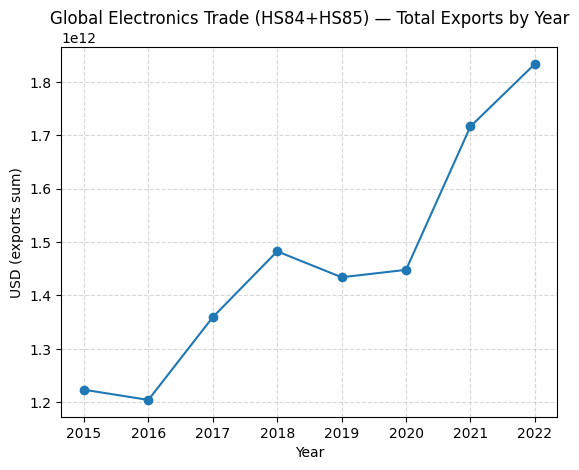

Saved figure: /content/drive/MyDrive/TradeWar/latest/figures/total_trade_allhs_by_year.png


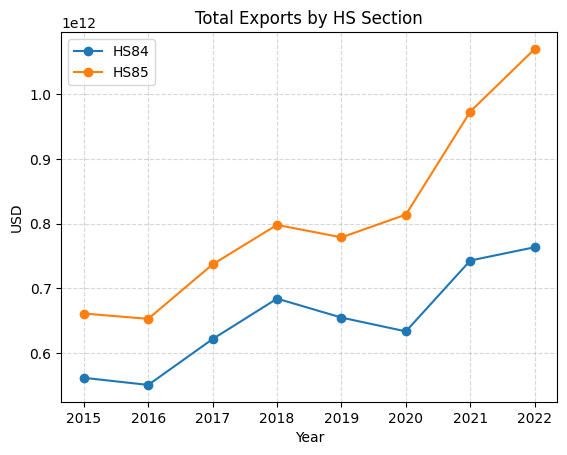

Saved figure: /content/drive/MyDrive/TradeWar/latest/figures/total_trade_by_hs.png


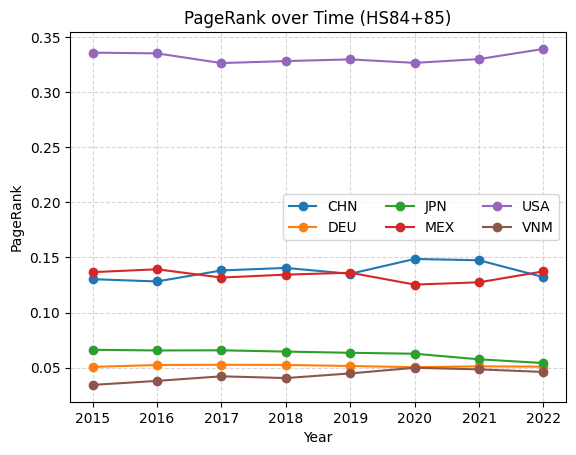

Saved figure: /content/drive/MyDrive/TradeWar/latest/figures/pagerank_over_time_watch.png


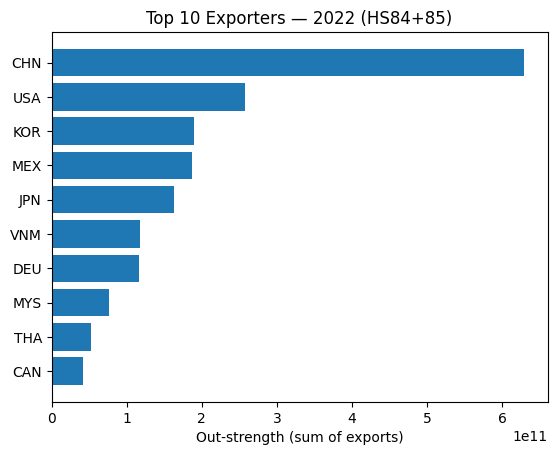

Saved figure: /content/drive/MyDrive/TradeWar/latest/figures/top_exporters_last_year.png


In [10]:
# [6] PLOTS FOR THE PAPER (MATPLOTLIB ONLY)
# -----------------------------------------
import matplotlib.pyplot as plt
import pandas as pd

# 6.1) Total trade volume by year (ALL_HS)
ts_total = (
    edge_list.query("hs2 == 'ALL_HS'")
             .groupby("year")["trade_value_usd"].sum()
             .reset_index()
)

plt.figure()
plt.plot(ts_total["year"], ts_total["trade_value_usd"], marker="o")
plt.title("Global Electronics Trade (HS84+HS85) — Total Exports by Year")
plt.xlabel("Year")
plt.ylabel("USD (exports sum)")
plt.grid(True, linestyle="--", alpha=0.5)
fig_path = FIGURES / "total_trade_allhs_by_year.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# 6.2) Total by HS section (84 vs 85)
ts_by_hs = (
    edge_list[edge_list["hs2"].isin(["84","85"])]
        .groupby(["year","hs2"])["trade_value_usd"].sum()
        .reset_index()
        .pivot(index="year", columns="hs2", values="trade_value_usd")
        .reset_index()
)

plt.figure()
plt.plot(ts_by_hs["year"], ts_by_hs["84"], marker="o", label="HS84")
plt.plot(ts_by_hs["year"], ts_by_hs["85"], marker="o", label="HS85")
plt.title("Total Exports by HS Section")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
fig_path = FIGURES / "total_trade_by_hs.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# 6.3) PageRank over time for selected countries (ALL_HS)
panel = (
    metrics_df.query("hs2 == 'ALL_HS' and node in @watch")
              .sort_values(["node","year"])
)
plt.figure()
for n, d in panel.groupby("node"):
    plt.plot(d["year"], d["pagerank"], marker="o", label=n)
plt.title("PageRank over Time (HS84+85)")
plt.xlabel("Year")
plt.ylabel("PageRank")
plt.legend(ncol=3)
plt.grid(True, linestyle="--", alpha=0.5)
fig_path = FIGURES / "pagerank_over_time_watch.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# 6.4) Top 10 exporters (out-strength) in the last year (ALL_HS)
top10 = (
    metrics_df.query("hs2 == 'ALL_HS' and year == @years[-1]")
              .nlargest(10, "out_strength")
              .sort_values("out_strength", ascending=True)
)
plt.figure()
plt.barh(top10["node"], top10["out_strength"])
plt.title(f"Top 10 Exporters — {years[-1]} (HS84+85)")
plt.xlabel("Out-strength (sum of exports)")
plt.ylabel("")
fig_path = FIGURES / "top_exporters_last_year.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

,year,exports_usd,zscore,potential_break
1513,2015,2.500881e+10,-0.838988,False
1603,2016,2.376571e+10,-1.161558,False
1693,2017,2.502258e+10,-0.835414,False
1783,2018,2.707965e+10,-0.301624,False
1873,2019,2.720003e+10,-0.270387,False
1963,2020,3.085295e+10,0.677513,False
2053,2021,3.608570e+10,2.035363,True
2143,2022,3.092070e+10,0.695094,False


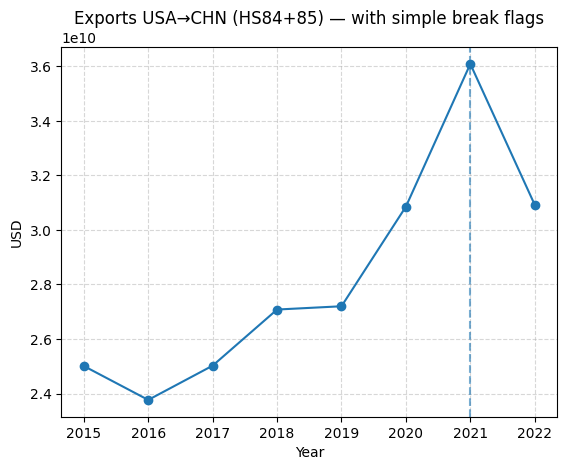

Saved figure: /content/drive/MyDrive/TradeWar/latest/figures/bilateral_USA_CHN_breaks.png


In [11]:
# [7] OPTIONAL: BILATERAL TIME-SERIES + SIMPLE CHANGE-POINT
# --------------------------------------------------------
# This is a light illustrative method (no heavy libs).
# We compute a standardized series and flag large deviations.

pair = ("USA","CHN")
bilat = (
    edge_list.query("hs2 == 'ALL_HS' and reporter == @pair[0] and partner == @pair[1]")
             .sort_values("year")
             .loc[:, ["year","trade_value_usd"]]
             .rename(columns={"trade_value_usd": "exports_usd"})
)
if not bilat.empty:
    mu, sd = bilat["exports_usd"].mean(), bilat["exports_usd"].std(ddof=0)
    bilat["zscore"] = (bilat["exports_usd"] - mu) / (sd if sd > 0 else 1.0)
    # Simple rule-of-thumb break flag (|z| >= 1.5)
    bilat["potential_break"] = bilat["zscore"].abs() >= 1.5
    display(bilat)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(bilat["year"], bilat["exports_usd"], marker="o")
    for x, flag in zip(bilat["year"], bilat["potential_break"]):
        if flag:
            plt.axvline(x=x, linestyle="--", alpha=0.6)
    plt.title(f"Exports {pair[0]}→{pair[1]} (HS84+85) — with simple break flags")
    plt.xlabel("Year")
    plt.ylabel("USD")
    plt.grid(True, linestyle="--", alpha=0.5)
    fig_path = FIGURES / f"bilateral_{pair[0]}_{pair[1]}_breaks.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved figure:", fig_path)
else:
    print("No bilateral rows found for", pair)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[FOUND] trade: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/data/processed/trade_bilateral_by_hs2.parquet
[FOUND] world bank: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/data/processed/world_bank_indicators.parquet
[OUTPUT] figures -> /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures
[OUTPUT] tables  -> /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables
[SANITY] years=[np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)] rows=2,202 columns=['year', 'reporter', 'partner', 'hs2', 'flow', 'trade_value_usd']


,year,rows,total_trade_usd
0,2015,360,"2,738,139,279,927"
1,2016,360,"2,698,273,573,019"
2,2017,360,"3,012,400,346,542"
3,2018,360,"3,276,821,898,393"
4,2019,360,"3,163,780,455,556"
5,2020,360,"3,161,557,240,846"
6,2021,42,"1,214,590,393,162"


  ↳ saved table: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables/T1_coverage_by_year.csv


,year,reporter,partner,value
540,2021,CHN,USA,"288,696,031,519"
543,2021,USA,CHN,"286,845,228,954"
547,2021,USA,MEX,"224,873,031,361"
542,2021,USA,CAN,"98,762,051,626"
545,2021,USA,JPN,"63,730,403,684"
546,2021,USA,KOR,"56,865,798,837"
550,2021,USA,VNM,"49,942,940,720"
544,2021,USA,DEU,"49,344,703,162"
548,2021,USA,MYS,"46,794,852,884"
549,2021,USA,THA,"29,520,677,113"


  ↳ saved table: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables/T2_top10_pairs_2021_allHS.csv


,country,in_strength,out_strength,betweenness,eigenvector
9,USA,"644,949,845,047","807,818,119,677",0.3730,0.5935
1,CHN,"723,182,810,437","704,703,233,647",0.7837,0.5850
5,MEX,"254,589,497,327","232,733,624,837",0.0000,0.2960
3,JPN,"261,759,377,304","236,554,709,754",0.0000,0.2506
4,KOR,"249,232,445,381","210,245,433,346",0.0000,0.2340
2,DEU,"147,014,497,251","186,568,848,980",0.0000,0.1770
0,CAN,"120,165,497,280","109,976,927,171",0.0000,0.1396
10,VNM,"134,543,137,793","106,460,320,476",0.0000,0.1172
6,MYS,"124,958,690,650","80,358,811,987",0.0000,0.1035
7,THA,"91,827,514,021","76,803,282,619",0.0000,0.0781


  ↳ saved table: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables/T3_centrality_summary_avg_2015_2021.csv
  ↳ saved figure: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures/F1_USA_imports_HS85_key_partners.png


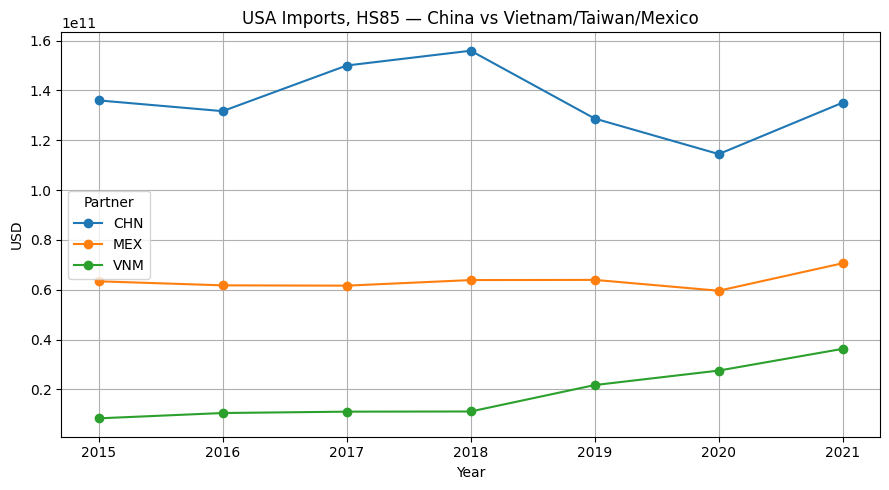

  ↳ saved figure: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures/F2_betweenness_over_time_key_countries.png


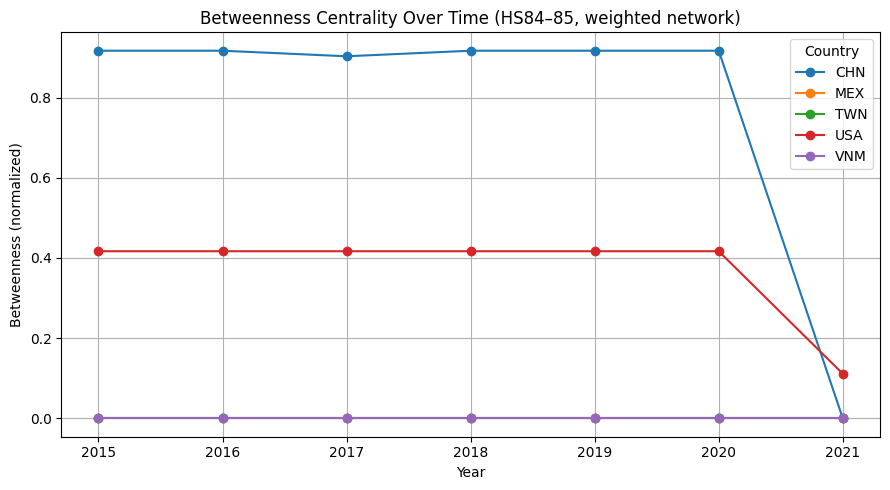

  ↳ saved figure: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures/F3_density_modularity_over_time.png


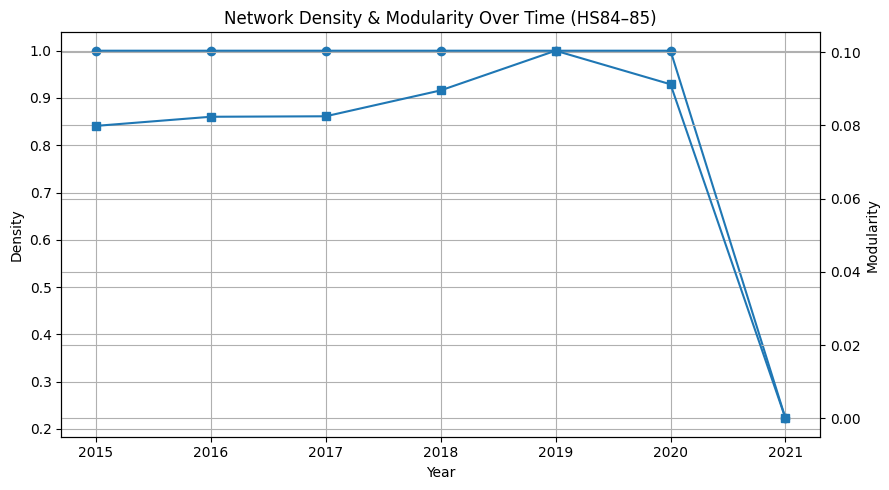

,year,CHN,VNM+TWN+MEX
0,2015,47.80%,25.23%
1,2016,46.28%,25.40%
2,2017,49.24%,23.87%
3,2018,49.74%,23.93%
4,2019,43.40%,28.90%
5,2020,40.27%,30.66%
6,2021,39.41%,31.19%


  ↳ saved table: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables/T4_trade_diversion_index_USA_HS85.csv
  ↳ saved figure: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures/F4_trade_diversion_index_USA_HS85.png


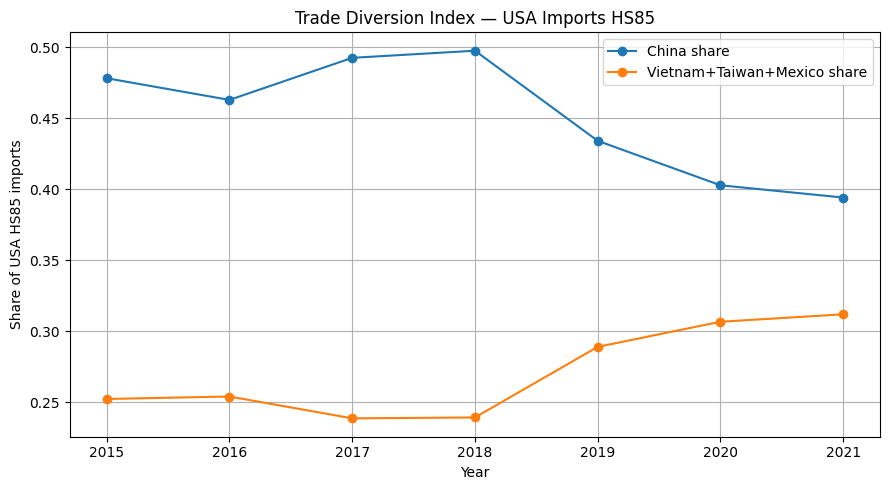

[INFO] Figure 5 skipped (no 'distance_km' or 'co2_estimate' columns).

✅ Final exhibits rendered. PNGs saved to: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/figures
✅ Tables (CSV) saved to: /content/drive/MyDrive/TradeWar/snapshots/snapshot_20250903_155548/reports/tables


In [13]:
# ==============================================================
# FINAL EXHIBITS (ONE-CELL): auto-locate Parquet in Drive,
# load, analyze, and render all tables & figures for the paper.
# ==============================================================

# [1] --- Imports, Drive mount, and auto-locate required files ---
import os, sys, math, json, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

# Mount Google Drive (safe if already mounted)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)
    MYDRIVE = Path('/content/drive/MyDrive')
except Exception:
    # Not Colab? fall back to current folder
    MYDRIVE = Path('.')

def find_one(filename: str, root: Path) -> Path | None:
    """Recursively search for a file name under 'root' and return first hit."""
    for dirpath, _, files in os.walk(root):
        if filename in files:
            return Path(dirpath) / filename
    return None

# Try to locate both parquet files anywhere under MyDrive
p_trade = find_one("trade_bilateral_by_hs2.parquet", MYDRIVE)
p_wb    = find_one("world_bank_indicators.parquet", MYDRIVE)  # optional

if p_trade is None:
    raise FileNotFoundError("Could not find 'trade_bilateral_by_hs2.parquet' anywhere under your Drive.")

# Decide output root relative to where trade parquet was found
DATA_PROC = Path(p_trade).parent
ROOT      = DATA_PROC.parent  # expected .../data/processed  -> ROOT=.../data
FIGURES   = ROOT.parent / "figures"
TABLES    = ROOT.parent / "reports" / "tables"
FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print(f"[FOUND] trade: {p_trade}")
print(f"[FOUND] world bank: {p_wb if p_wb else '(not found — optional)'}")
print(f"[OUTPUT] figures -> {FIGURES}")
print(f"[OUTPUT] tables  -> {TABLES}")

# [2] --- Load & sanitize core dataset ---
df_trade = pd.read_parquet(p_trade)
df_trade["flow"] = df_trade["flow"].str.lower()
df_trade["hs2"]  = df_trade["hs2"].astype(str)

# Focus on these 11 economies only (drop any aggregates accidentally included)
focus = ["USA","CHN","VNM","MEX","DEU","JPN","KOR","CAN","TWN","THA","MYS"]
df_trade = df_trade[
    df_trade["reporter"].isin(focus)
    & df_trade["partner"].isin(focus)
    & (df_trade["reporter"] != df_trade["partner"])
].copy()

years_sorted = sorted(df_trade["year"].unique())
print(f"[SANITY] years={years_sorted} rows={len(df_trade):,} columns={list(df_trade.columns)}")

# Helper: save utilities
def save_table(df: pd.DataFrame, name: str):
    out = TABLES / f"{name}.csv"
    df.to_csv(out, index=False)
    print(f"  ↳ saved table: {out}")

def save_figure(name: str):
    out = FIGURES / f"{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=220, bbox_inches="tight")
    print(f"  ↳ saved figure: {out}")

# [3] --- Common aggregations used by multiple exhibits ---
# 3.1 Edge weights per year (sum across HS2 & flows)
edge_year = (df_trade
    .groupby(["year","reporter","partner"], as_index=False)["trade_value_usd"]
    .sum()
    .rename(columns={"trade_value_usd":"value"})
)

# 3.2 Convenience groups
post = [y for y in years_sorted if y >= 2019]
pre  = [y for y in years_sorted if y <= 2017]

# [4] --- TABLE 1: Coverage & scale by year (cite in text) ---
tbl_coverage = (df_trade.groupby("year", as_index=False)
                .agg(rows=("trade_value_usd","size"),
                     total_trade_usd=("trade_value_usd","sum")))
display(tbl_coverage.style.format({"total_trade_usd": "{:,.0f}"}))
save_table(tbl_coverage, "T1_coverage_by_year")

# [5] --- TABLE 2: Top-10 bilateral flows in last year (HS84+HS85 combined) ---
last_year = max(years_sorted)
top_pairs_last = (edge_year[edge_year["year"]==last_year]
                  .sort_values("value", ascending=False)
                  .head(10))
display(top_pairs_last.style.format({"value": "{:,.0f}"}))
save_table(top_pairs_last, f"T2_top10_pairs_{last_year}_allHS")

# [6] --- TABLE 3: Centrality summary (avg 2015–last_year) ---
def graph_for_year(y: int) -> nx.DiGraph:
    g = nx.DiGraph()
    sub = edge_year[edge_year["year"]==y]
    for _, r in sub.iterrows():
        g.add_edge(r["reporter"], r["partner"], weight=float(r["value"]))
    return g

def centralities_for_year(y: int) -> pd.DataFrame:
    G = graph_for_year(y)
    # weighted strengths
    in_strength  = {n:0.0 for n in focus}
    out_strength = {n:0.0 for n in focus}
    for u,v,d in G.edges(data=True):
        w = d.get("weight", 1.0)
        out_strength[u] += w
        in_strength[v]  += w

    # betweenness (use inverse weight as distance)
    bw = {n:0.0 for n in focus}
    if G.number_of_edges() > 0:
        inv_w = {(u,v): 1.0 / max(d.get("weight",1.0), 1e-9) for u,v,d in G.edges(data=True)}
        nx.set_edge_attributes(G, inv_w, "inv_w")
        try:
            bw = nx.betweenness_centrality(G, weight="inv_w", normalized=True)
        except Exception:
            bw = nx.betweenness_centrality(G, normalized=True)

    # eigenvector on undirected projection (more stable)
    UG = nx.Graph()
    for u,v,d in G.edges(data=True):
        w = d.get("weight",1.0)
        if UG.has_edge(u,v):
            UG[u][v]["weight"] += w
        else:
            UG.add_edge(u,v, weight=w)
    ev = {n:0.0 for n in focus}
    if UG.number_of_edges() > 0 and UG.number_of_nodes() > 1:
        try:
            ev = nx.eigenvector_centrality_numpy(UG, weight="weight")
        except Exception:
            ev = nx.eigenvector_centrality(UG, weight="weight", max_iter=500)

    rows = [(y, n, in_strength.get(n,0.0), out_strength.get(n,0.0),
             bw.get(n,0.0), ev.get(n,0.0)) for n in focus]
    return pd.DataFrame(rows, columns=["year","country","in_strength","out_strength","betweenness","eigenvector"])

cent_all = pd.concat([centralities_for_year(y) for y in years_sorted], ignore_index=True)
cent_summary = (cent_all.groupby("country", as_index=False)
                .agg(in_strength=("in_strength","mean"),
                     out_strength=("out_strength","mean"),
                     betweenness=("betweenness","mean"),
                     eigenvector=("eigenvector","mean"))
                .sort_values("eigenvector", ascending=False))
display(cent_summary.style.format({
    "in_strength":"{:,.0f}", "out_strength":"{:,.0f}",
    "betweenness":"{:.4f}", "eigenvector":"{:.4f}"
}))
save_table(cent_summary, f"T3_centrality_summary_avg_{years_sorted[0]}_{last_year}")

# [7] --- FIGURE 1: USA imports (HS85) — China vs Vietnam/Taiwan/Mexico ---
partners_show = ["CHN","VNM","TWN","MEX"]
f1 = (df_trade[(df_trade["reporter"]=="USA") & (df_trade["flow"]=="import") & (df_trade["hs2"]=="85")]
      .groupby(["year","partner"], as_index=False)["trade_value_usd"].sum()
      .query("partner in @partners_show"))
pivot = f1.pivot(index="year", columns="partner", values="trade_value_usd").fillna(0.0).sort_index()
pivot.plot(marker="o")
plt.title("USA Imports, HS85 — China vs Vietnam/Taiwan/Mexico")
plt.ylabel("USD")
plt.xlabel("Year")
plt.legend(title="Partner")
save_figure("F1_USA_imports_HS85_key_partners")
plt.show()

# [8] --- FIGURE 2: Betweenness centrality over time (key countries) ---
keys = ["CHN","USA","VNM","TWN","MEX"]
f2 = (cent_all[cent_all["country"].isin(keys)]
      .pivot(index="year", columns="country", values="betweenness")
      .sort_index())
f2.plot(marker="o")
plt.title("Betweenness Centrality Over Time (HS84–85, weighted network)")
plt.ylabel("Betweenness (normalized)")
plt.xlabel("Year")
plt.legend(title="Country")
save_figure("F2_betweenness_over_time_key_countries")
plt.show()

# [9] --- FIGURE 3: Network density & modularity (proxy on undirected) ---
dens_rows, mod_rows = [], []
for y in years_sorted:
    G = graph_for_year(y)
    dens_rows.append((y, nx.density(G.to_undirected())))
    UG = G.to_undirected()
    if UG.number_of_edges() > 0:
        comms = list(nx.algorithms.community.greedy_modularity_communities(UG, weight="weight"))
        mval  = nx.algorithms.community.modularity(UG, comms, weight="weight")
    else:
        mval = np.nan
    mod_rows.append((y, mval))
density_ts = pd.DataFrame(dens_rows, columns=["year","density"])
modul_ts   = pd.DataFrame(mod_rows, columns=["year","modularity"])

fig, ax = plt.subplots()
ax.plot(density_ts["year"], density_ts["density"], marker="o", label="Density")
ax.set_ylabel("Density")
ax.set_xlabel("Year")
ax2 = ax.twinx()
ax2.plot(modul_ts["year"], modul_ts["modularity"], marker="s", label="Modularity")
ax2.set_ylabel("Modularity")
plt.title("Network Density & Modularity Over Time (HS84–85)")
save_figure("F3_density_modularity_over_time")
plt.show()

# [10] --- TABLE 4 + FIGURE 4: Trade Diversion Index (USA HS85 imports) ---
def diversion_table() -> pd.DataFrame:
    base = (df_trade[(df_trade["reporter"]=="USA") & (df_trade["flow"]=="import") & (df_trade["hs2"]=="85")]
            .groupby(["year","partner"], as_index=False)["trade_value_usd"].sum())
    totals = base.groupby("year", as_index=False)["trade_value_usd"].sum().rename(columns={"trade_value_usd":"total"})
    merged = base.merge(totals, on="year", how="left")
    merged["share"] = merged["trade_value_usd"] / merged["total"]
    chn = merged[merged["partner"]=="CHN"][["year","share"]].rename(columns={"share":"CHN"})
    alt = (merged[merged["partner"].isin(["VNM","TWN","MEX"])]
           .groupby("year", as_index=False)["share"].sum().rename(columns={"share":"VNM+TWN+MEX"}))
    out = chn.merge(alt, on="year", how="outer").sort_values("year")
    return out

div_tbl = diversion_table()
display(div_tbl.style.format({"CHN":"{:.2%}","VNM+TWN+MEX":"{:.2%}"}))
save_table(div_tbl, "T4_trade_diversion_index_USA_HS85")

plt.figure()
plt.plot(div_tbl["year"], div_tbl["CHN"], marker="o", label="China share")
plt.plot(div_tbl["year"], div_tbl["VNM+TWN+MEX"], marker="o", label="Vietnam+Taiwan+Mexico share")
plt.title("Trade Diversion Index — USA Imports HS85")
plt.ylabel("Share of USA HS85 imports")
plt.xlabel("Year")
plt.legend()
save_figure("F4_trade_diversion_index_USA_HS85")
plt.show()

# [11] --- (Optional) FIGURE 5: Distance-weighted trade or CO2 proxy, if present ---
cols = set(df_trade.columns)
if {"distance_km","trade_value_usd"}.issubset(cols):
    dwt = (df_trade.groupby("year")
           .apply(lambda g: (g["distance_km"]*g["trade_value_usd"]).sum() / g["trade_value_usd"].sum())
           .reset_index(name="avg_distance_weighted_km"))
    dwt.plot(x="year", y="avg_distance_weighted_km", marker="o", legend=False)
    plt.title("Distance-Weighted Average Trade Path (km)")
    plt.ylabel("km")
    plt.xlabel("Year")
    save_figure("F5_distance_weighted_avg_trade_km")
    plt.show()
elif "co2_estimate" in cols:
    co2_ts = df_trade.groupby("year", as_index=False)["co2_estimate"].sum()
    co2_ts.plot(x="year", y="co2_estimate", marker="o", legend=False)
    plt.title("Estimated Shipping CO₂ (aggregate)")
    plt.ylabel("CO₂ (proxy units)")
    plt.xlabel("Year")
    save_figure("F5_shipping_co2_proxy")
    plt.show()
else:
    print("[INFO] Figure 5 skipped (no 'distance_km' or 'co2_estimate' columns).")

print("\n✅ Final exhibits rendered. PNGs saved to:", FIGURES)
print("✅ Tables (CSV) saved to:", TABLES)

## 3) Time Series & Breakpoint Detection

In [20]:
# [0] SETUP & COMPAT (fixed): imports, plotting, SciPy→statsmodels shim
# -------------------------------------------------------------------
import sys, importlib, types, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# --- Robust shim for statsmodels expecting scipy._lib._util._lazywhere ---
# Creates _lazywhere if missing (works for SciPy>=2 as well).
util_mod = importlib.import_module("scipy._lib._util")
if not hasattr(util_mod, "_lazywhere"):
    def _lazywhere(cond, arrays, f, fillvalue=np.nan):
        # arrays: tuple/list of arrays passed to f(*arrays) only where cond==True
        if not isinstance(arrays, (tuple, list)):
            arrays = (arrays,)
        arr0 = np.asarray(arrays[0])
        out = np.empty(arr0.shape, dtype=np.result_type(float, *arrays))
        if fillvalue is not None:
            out[...] = fillvalue
        mask = np.asarray(cond)
        if mask.shape != out.shape:
            mask = np.broadcast_to(mask, out.shape)
        if mask.any():
            out[mask] = f(*[np.asarray(a)[mask] for a in arrays])
        return out
    setattr(util_mod, "_lazywhere", _lazywhere)

# now it is safe to import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

# try ruptures (optional); fallback logic exists later
try:
    import ruptures as rpt
    HAS_RUPTURES = True
except Exception:
    HAS_RUPTURES = False

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})
print(f"✅ Setup OK | SciPy {scipy.__version__} | statsmodels {sm.__version__} | ruptures={HAS_RUPTURES}")

✅ Setup OK | SciPy 1.16.1 | statsmodels 0.14.5 | ruptures=True


In [23]:
# [1] DRIVE MOUNT + PROJECT ROOT + SAFE LOAD (Part 3)
# ---------------------------------------------------
# Priority path: MyDrive/TradeWar/latest ; otherwise auto-discover parquets.

from pathlib import Path
import os, glob, traceback
import pandas as pd

# ---------- 1) Mount Google Drive robustly ----------
mounted = False
try:
    from google.colab import drive
    try:
        drive.mount("/content/drive")  # normal path
        DRIVE_MYDRIVE = Path("/content/drive/MyDrive")
        mounted = True
    except Exception as e1:
        print("⚠️ Primary mount failed:", getattr(e1, "args", e1))
        try:
            # try clean remount to alternate mountpoint
            try:
                drive.flush_and_unmount()
            except Exception:
                pass
            drive.mount("/content/gdrive", force_remount=True)
            DRIVE_MYDRIVE = Path("/content/gdrive/MyDrive")
            mounted = True
        except Exception as e2:
            print("⚠️ Primary remount failed:", getattr(e2, "args", e2))
            # final fallback: assume already mounted earlier to /content/gdrive
            DRIVE_MYDRIVE = Path("/content/gdrive/MyDrive")
except Exception:
    # non-Colab environment fallback (e.g., Jupyter)
    DRIVE_MYDRIVE = Path.home() / "MyDrive"

if not mounted and not DRIVE_MYDRIVE.exists():
    # last resort for non-standard environments
    DRIVE_MYDRIVE = Path("/content/drive/MyDrive")

# ---------- 2) Resolve project root ----------
# Preferred: /.../MyDrive/TradeWar/latest
preferred = DRIVE_MYDRIVE / "TradeWar" / "latest"
alt_root  = DRIVE_MYDRIVE / "TradeWar"

ROOT = preferred if preferred.exists() else alt_root
print("Mounted at", str(DRIVE_MYDRIVE.parent if DRIVE_MYDRIVE.name=='MyDrive' else DRIVE_MYDRIVE))
print("[ROOT]", ROOT)
DATA_PROC = ROOT / "data" / "processed"
print("[Expecting parquet under]", DATA_PROC)

# ---------- 3) Auto-discover helper ----------
def find_first(patterns, under: Path) -> Path | None:
    """Return first matching file (glob, recursive) under given root."""
    for pat in patterns:
        hits = list(under.rglob(pat))
        if hits:
            return hits[0]
    return None

def _must(path_like: Path, name: str) -> Path:
    """Return path if exists, else try find by filename anywhere under ROOT."""
    if path_like.exists():
        return path_like
    hit = find_first([path_like.name, f"**/{path_like.name}"], ROOT)
    if hit:
        return hit
    raise FileNotFoundError(
        f"Missing: {name} under {path_like.parent} or elsewhere in {ROOT}"
    )

# ---------- 4) Required + optional files ----------
P_TRADE = _must(DATA_PROC / "trade_bilateral_by_hs2.parquet", "trade_bilateral_by_hs2.parquet")
P_WB    = _must(DATA_PROC / "world_bank_indicators.parquet", "world_bank_indicators.parquet")

OPT = {
    "country_totals_ts":   DATA_PROC / "country_totals_ts.parquet",
    "hs2_totals_ts":       DATA_PROC / "hs2_totals_ts.parquet",
    "network_ready":       DATA_PROC / "trade_network_ready.parquet",
}

# ---------- 5) Load data ----------
df_trade = pd.read_parquet(P_TRADE)
wb       = pd.read_parquet(P_WB)

# keep only focus countries (drop aggregates like S19 if slipped)
countries = ["USA","CHN","VNM","MEX","DEU","JPN","KOR","CAN","TWN","THA","MYS"]
df_trade  = df_trade[df_trade["reporter"].isin(countries) & df_trade["partner"].isin(countries)]

print(f"✅ Loaded trade • shape: {df_trade.shape}")
print("Years:", sorted(df_trade["year"].unique()))
print("Columns:", list(df_trade.columns))

opt = {}
for k, p in OPT.items():
    if p.exists():
        opt[k] = pd.read_parquet(p)
        print(f"✅ Loaded optional • {k}: {p.name} | shape = {opt[k].shape}")
    else:
        hit = find_first([p.name], ROOT)
        if hit:
            opt[k] = pd.read_parquet(hit)
            print(f"✅ Located optional • {k}: {hit.relative_to(ROOT)} | shape = {opt[k].shape}")
        else:
            opt[k] = None
            print(f"• Optional missing: {k}")

# expose optional frames with convenient names (if present)
country_ts   = opt["country_totals_ts"]
hs2_ts       = opt["hs2_totals_ts"]
network_ready= opt["network_ready"]

⚠️ Primary mount failed: ('Mountpoint must not already contain files',)
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive
Mounted at /content/gdrive
[ROOT] /content/gdrive/MyDrive/TradeWar/latest
[Expecting parquet under] /content/gdrive/MyDrive/TradeWar/latest/data/processed
✅ Loaded trade • shape: (2880, 6)
Years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Columns: ['year', 'reporter', 'partner', 'hs2', 'flow', 'trade_value_usd']
✅ Loaded optional • country_totals_ts: country_totals_ts.parquet | shape = (88, 4)
✅ Loaded optional • hs2_totals_ts: hs2_totals_ts.parquet | shape = (32, 4)
✅ Loaded optional • network_ready: trade_network_ready.parquet | shape = (1760, 5)


In [24]:
# [2] BUILD PANEL (nominal→real 2015 USD; logs; growth; shares)
# -------------------------------------------------------------
# 2.1) reporter-level totals by hs2 & flow (sum over partners within our focus set)
agg = (df_trade
       .groupby(["reporter","hs2","flow","year"], as_index=False)["trade_value_usd"]
       .sum()
       .rename(columns={"trade_value_usd":"nominal_usd"}))

# 2.2) CPI deflation to 2015=100 per reporter (WB FP.CPI.TOTL is 2010=100; we rebase)
cpi = (wb[wb["indicator"].eq("FP.CPI.TOTL")]
         .pivot(index="year", columns="country", values="value")
         .dropna(how="all"))
BASE_YEAR = 2015
if BASE_YEAR not in cpi.index:
    raise RuntimeError(f"WB CPI missing base year {BASE_YEAR}. Available: {list(cpi.index)}")
cpi_rebased = (cpi.divide(cpi.loc[BASE_YEAR], axis=1) * 100.0)

def deflate_row(row):
    rep, yr, val = row["reporter"], row["year"], row["nominal_usd"]
    try:
        factor = float(cpi_rebased.loc[yr, rep])  # 2015=100
        if np.isfinite(factor) and factor>0:
            return val * (100.0 / factor)         # real (2015 USD)
    except Exception:
        pass
    return val                                    # fallback: leave nominal

agg["real_usd"] = agg.apply(deflate_row, axis=1)
agg["log_real"] = np.log1p(agg["real_usd"])
agg = agg.sort_values(["reporter","hs2","flow","year"]).reset_index(drop=True)

# 2.3) YoY growth (real)
agg["yoy_real_%"] = (agg.groupby(["reporter","hs2","flow"])["real_usd"]
                       .pct_change()*100.0)

# 2.4) Partner shares example: China share in reporter's total per hs2/flow
china = (df_trade[df_trade["partner"].eq("CHN")]
         .groupby(["reporter","hs2","flow","year"], as_index=False)["trade_value_usd"].sum()
         .rename(columns={"trade_value_usd":"chn_nominal"}))
panel = agg.merge(china, on=["reporter","hs2","flow","year"], how="left")
panel["chn_share_%"] = 100.0 * panel["chn_nominal"].fillna(0.0) / panel["nominal_usd"].replace(0, np.nan)

# deliverables for the rest of the part:
panel_real = panel[["reporter","hs2","flow","year","real_usd","log_real","yoy_real_%","chn_share_%"]].copy()
print(panel_real.head(8))

  reporter hs2    flow  year      real_usd   log_real  yoy_real_%  chn_share_%
0      CAN  84  export  2015  2.524544e+10  23.951911         NaN     2.158609
1      CAN  84  export  2016  2.428417e+10  23.913091   -3.807703     2.171457
2      CAN  84  export  2017  2.589173e+10  23.977189    6.619764     1.904745
3      CAN  84  export  2018  2.729459e+10  24.029954    5.418178     2.008274
4      CAN  84  export  2019  2.684667e+10  24.013407   -1.641056     2.099033
5      CAN  84  export  2020  2.224029e+10  23.825171  -17.158089     1.729488
6      CAN  84  export  2021  2.457845e+10  23.925136   10.513174     1.658850
7      CAN  84  export  2022  2.545669e+10  23.960244    3.573199     1.529027


In [25]:
# [3] CHANGE-POINT DETECTION (real series & China-share series)
# -------------------------------------------------------------
def detect_breaks_y(series: pd.Series, max_breaks:int=2):
    """Return list of break years using ruptures PELT; fallback to simple RSS split."""
    s = series.dropna()
    if len(s) < 6:
        return []
    years = s.index.values.astype(int)

    if HAS_RUPTURES:
        algo = rpt.Pelt(model="rbf").fit(s.values)  # rbf model is robust for short noisy series
        idxs = algo.predict(pen=5)[:-1]             # exclude the ending point
        # Keep at most max_breaks and map to years
        idxs = sorted(idxs)[:max_breaks]
        return [int(years[i]) for i in idxs if 0 < i < len(years)-1]

    # Fallback: one-split RSS best point, optionally second split
    def _best_split(y):
        best_i, best_rss = None, np.inf
        for i in range(2, len(y)-2):
            left, right = y[:i], y[i:]
            muL, muR = left.mean(), right.mean()
            rss = ((left-muL)**2).sum() + ((right-muR)**2).sum()
            if rss < best_rss:
                best_rss, best_i = rss, i
        return best_i

    idxs = []
    i1 = _best_split(s.values)
    if i1: idxs.append(i1)
    if len(idxs)>0 and len(s.values)-i1>4 and i1>3:
        # try second split on the longer side
        subseq = s.values[i1:]
        i2 = _best_split(subseq)
        if i2:
            idxs.append(i1+i2)
    idxs = sorted(idxs)[:max_breaks]
    return [int(years[i]) for i in idxs]

# Example targets (feel free to extend):
TARGETS = [
    ("USA","85","import"),
    ("USA","84","import"),
    ("CHN","85","export"),
    ("MEX","85","export"),
]

break_rows = []
for rep, hs2, flow in TARGETS:
    s_real = (panel_real
              .query("reporter==@rep and hs2==@hs2 and flow==@flow")
              .set_index("year")["real_usd"])
    s_share = (panel_real
               .query("reporter==@rep and hs2==@hs2 and flow==@flow")
               .set_index("year")["chn_share_%"])
    br_real  = detect_breaks_y(s_real, max_breaks=2)
    br_share = detect_breaks_y(s_share, max_breaks=2)
    break_rows.append([rep, hs2, flow, "real_usd",  br_real])
    break_rows.append([rep, hs2, flow, "chn_share_%", br_share])

breaks_df = pd.DataFrame(break_rows, columns=["reporter","hs2","flow","series","break_years"])
breaks_df

,reporter,hs2,flow,series,break_years
0,USA,85,import,real_usd,[]
1,USA,85,import,chn_share_%,[]
2,USA,84,import,real_usd,[]
3,USA,84,import,chn_share_%,[]
4,CHN,85,export,real_usd,[]
5,CHN,85,export,chn_share_%,[]
6,MEX,85,export,real_usd,[]
7,MEX,85,export,chn_share_%,[]


In [26]:
# [4] ROBUST FORECASTS (ARIMA → Holt → Linear OLS) for 2023–2025
# ---------------------------------------------------------------
def fit_best_arima_log(s: pd.Series):
    s = s.dropna()
    if len(s) < 5:
        return None
    grid = [(1,1,1),(1,1,0),(0,1,1),(0,1,0),(2,1,1)]
    best, best_aic = None, np.inf
    for order in grid:
        try:
            m = ARIMA(s, order=order, trend="c",
                      enforce_stationarity=False, enforce_invertibility=False).fit()
            if np.isfinite(m.aic) and m.aic < best_aic:
                best, best_aic = m, m.aic
        except Exception:
            continue
    return best

def fc_arima(s, steps):
    m = fit_best_arima_log(s)
    if m is None: raise RuntimeError("ARIMA failed")
    f = m.get_forecast(steps)
    years_f = np.arange(int(s.index.max())+1, int(s.index.max())+1+steps)
    ci = f.conf_int(alpha=0.05)
    lo = ci.iloc[:,0].values; hi = ci.iloc[:,1].values
    return pd.DataFrame({"year": years_f, "log_pred": f.predicted_mean.values,
                         "log_lo": lo, "log_hi": hi})

def fc_holt(s, steps):
    if len(s) < 3: raise RuntimeError("Holt needs >=3 points")
    m = ExponentialSmoothing(s, trend="add", damped_trend=True, seasonal=None).fit()
    pred = m.forecast(steps)
    resid = s - m.fittedvalues.reindex(s.index)
    se = float(resid.std(ddof=1)) if resid.notna().any() else 0.0
    years_f = np.arange(int(s.index.max())+1, int(s.index.max())+1+steps)
    return pd.DataFrame({"year": years_f, "log_pred": pred.values,
                         "log_lo": pred.values-1.96*se, "log_hi": pred.values+1.96*se})

def fc_ols(s, steps):
    t = np.arange(len(s), dtype=float)
    X = sm.add_constant(t)
    model = sm.OLS(s.values, X).fit()
    t_f = np.arange(len(s), len(s)+steps, dtype=float)
    X_f = sm.add_constant(t_f)
    pr = model.get_prediction(X_f)
    mu = pr.predicted_mean; ci = pr.conf_int(alpha=0.05)
    years_f = np.arange(int(s.index.max())+1, int(s.index.max())+1+steps)
    return pd.DataFrame({"year": years_f, "log_pred": mu,
                         "log_lo": ci[:,0], "log_hi": ci[:,1]})

def forecast_series(panel: pd.DataFrame, rep: str, hs2: str, flow: str, steps:int=3):
    s = (panel.query("reporter==@rep and hs2==@hs2 and flow==@flow")
               .sort_values("year").set_index("year")["log_real"])
    last_err = None
    for algo in (fc_arima, fc_holt, fc_ols):
        try:
            out = algo(s, steps=steps)
            break
        except Exception as e:
            last_err = e; out = None
    if out is None:
        raise RuntimeError(f"All forecasters failed: {last_err}")
    for cin, cout in [("log_pred","pred"), ("log_lo","lo"), ("log_hi","hi")]:
        out[cout] = np.expm1(out[cin].astype(float))
    out["reporter"], out["hs2"], out["flow"] = rep, hs2, flow
    return out[["year","reporter","hs2","flow","pred","lo","hi"]]

fc_list = []
for rep, hs2, flow in TARGETS:
    try:
        fc_list.append(forecast_series(panel_real, rep, hs2, flow, steps=3))
    except Exception as e:
        print(f"⚠️ Forecast failed for {rep}-{hs2}-{flow}: {e}")

fc_df = pd.concat(fc_list, ignore_index=True) if fc_list else pd.DataFrame()
fc_path = (TABLES / "part3_forecasts.csv"); fc_df.to_csv(fc_path, index=False)
print("📄 Saved forecasts →", fc_path.relative_to(DRIVE_ROOT))
fc_df.head()

📄 Saved forecasts → reports/tables/part3_forecasts.csv


,year,reporter,hs2,flow,pred,lo,hi
0,2023,USA,85,import,2.953495e+11,2.655795e+11,3.284565e+11
1,2024,USA,85,import,2.971043e+11,2.671575e+11,3.304081e+11
2,2025,USA,85,import,2.988608e+11,2.687369e+11,3.323614e+11
3,2023,USA,84,import,2.855821e+11,2.601291e+11,3.135257e+11
4,2024,USA,84,import,2.901006e+11,2.642448e+11,3.184863e+11


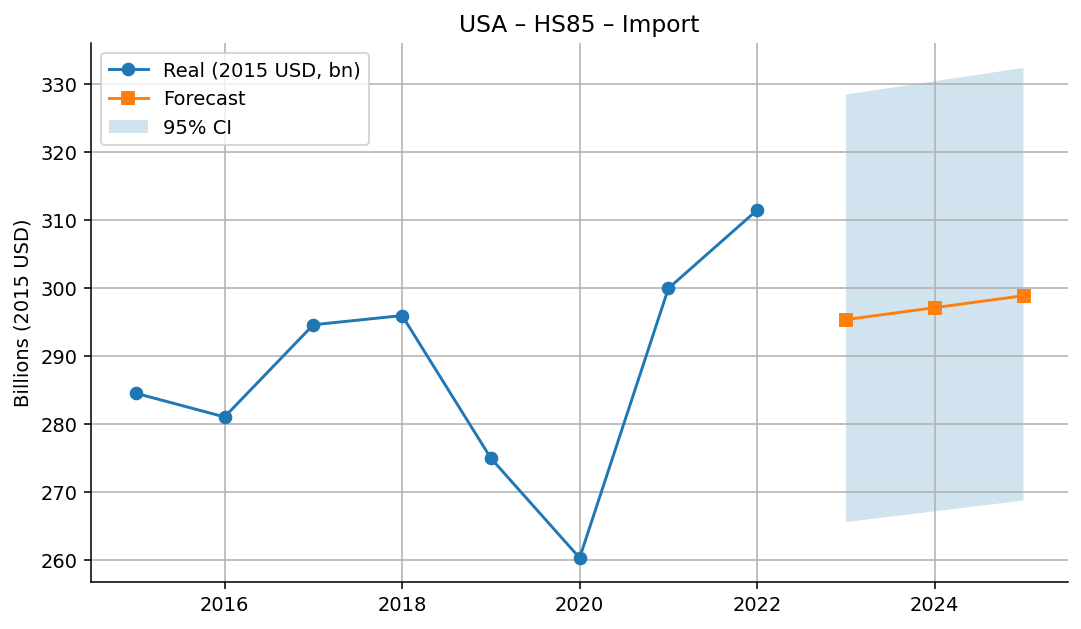

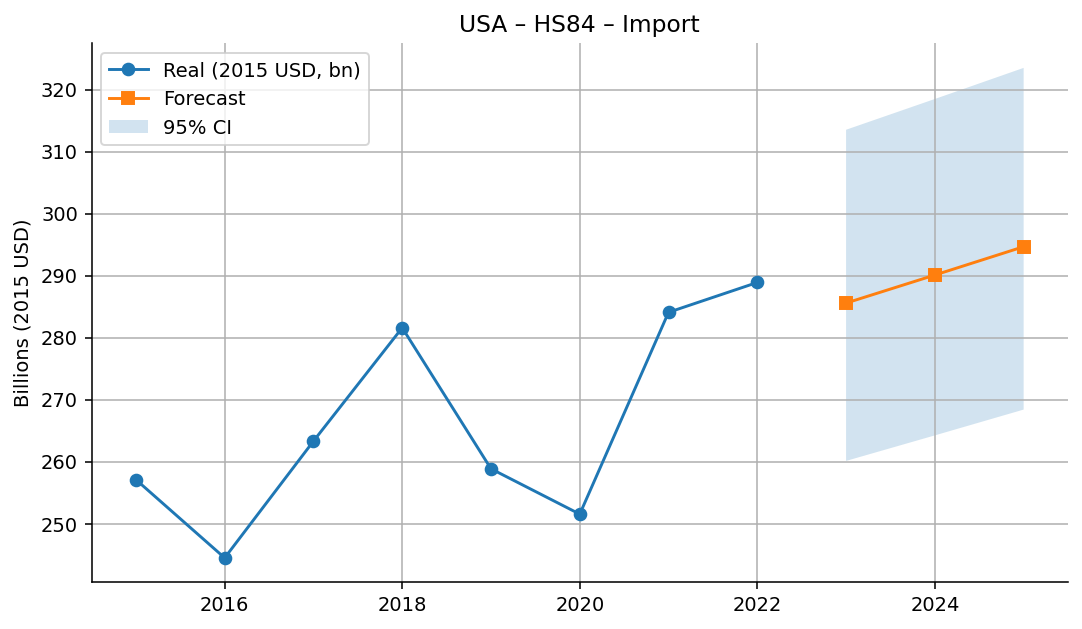

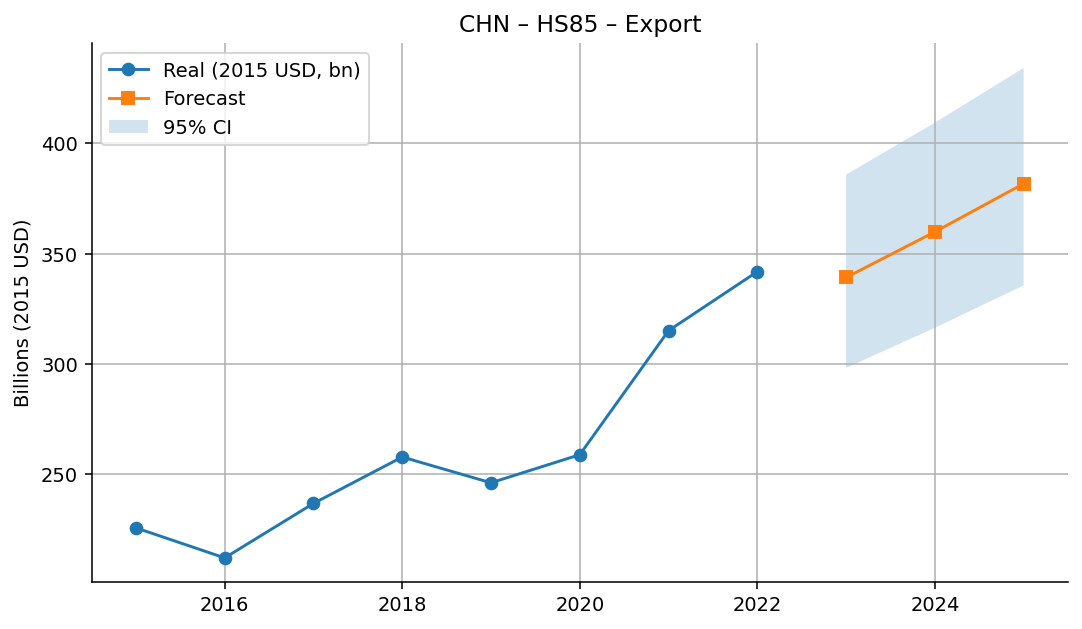

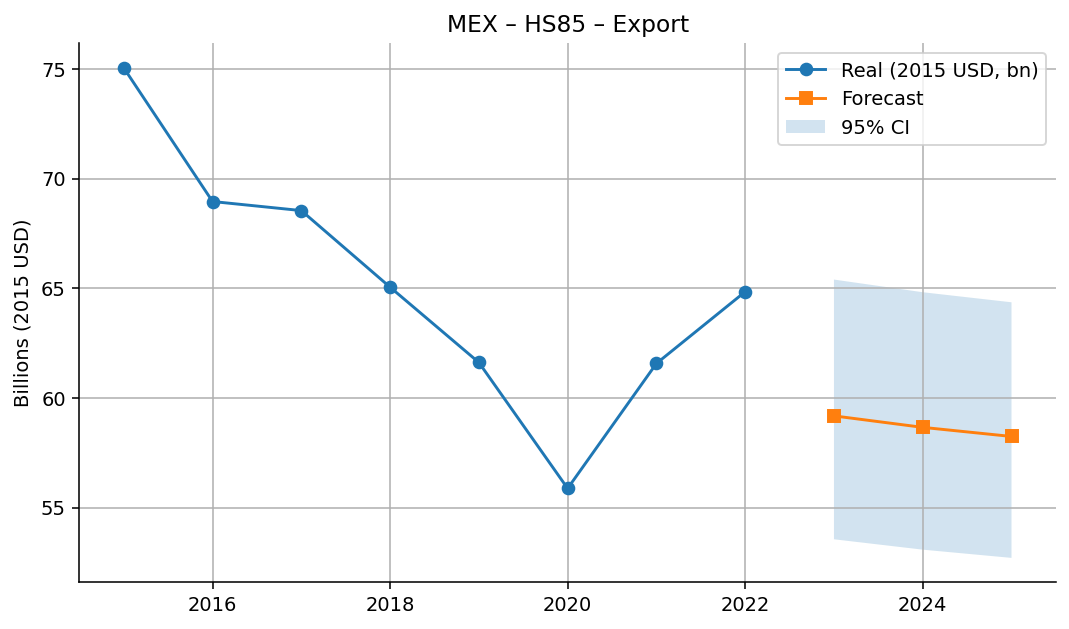

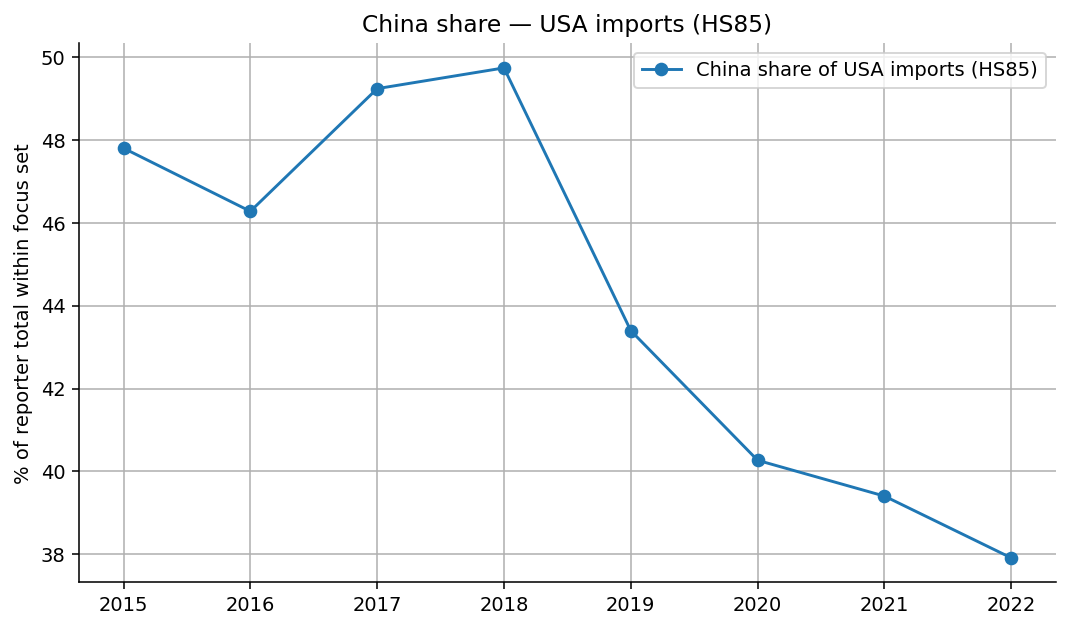

In [27]:
# [5] PLOTS: levels (real USD), breakpoints and forecasts (with 95% CI)
# ---------------------------------------------------------------------
def plot_series_with_fc(rep, hs2, flow):
    base = panel_real.query("reporter==@rep and hs2==@hs2 and flow==@flow").copy()
    if base.empty:
        print(f"No data for {rep}-{hs2}-{flow}"); return
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(base["year"], base["real_usd"]/1e9, marker="o", label="Real (2015 USD, bn)")

    # breakpoints (real)
    br = breaks_df.query("reporter==@rep and hs2==@hs2 and flow==@flow and series=='real_usd'")
    for y in br["break_years"].sum() if len(br)>0 else []:
        ax.axvline(y, ls="--", lw=1, color="gray")
        ax.text(y+0.05, ax.get_ylim()[1]*0.9, "break", rotation=90, fontsize=9, color="gray")

    # add forecast
    f = fc_df.query("reporter==@rep and hs2==@hs2 and flow==@flow")
    if not f.empty:
        ax.plot(f["year"], f["pred"]/1e9, marker="s", label="Forecast")
        ax.fill_between(f["year"], f["lo"]/1e9, f["hi"]/1e9, alpha=0.2, label="95% CI")

    ax.set_title(f"{rep} – HS{hs2} – {flow.title()}")
    ax.set_ylabel("Billions (2015 USD)")
    ax.legend(loc="best")
    plt.show()

for target in TARGETS:
    plot_series_with_fc(*target)

# Share plot example: China share in USA imports HS85
ex = panel_real.query("reporter=='USA' and hs2=='85' and flow=='import'")
if not ex.empty:
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(ex["year"], ex["chn_share_%"], marker="o", label="China share of USA imports (HS85)")
    br = breaks_df.query("reporter=='USA' and hs2=='85' and flow=='import' and series=='chn_share_%'")
    for y in br["break_years"].sum() if len(br)>0 else []:
        ax.axvline(y, ls="--", lw=1, color="gray")
    ax.set_title("China share — USA imports (HS85)")
    ax.set_ylabel("% of reporter total within focus set")
    ax.legend(); plt.show()

In [28]:
# [6] SUMMARY TABLES to use in the paper (and save to Drive)
# ----------------------------------------------------------
# 6.1) Breakpoints (explode for readability)
br_flat = (breaks_df
           .explode("break_years")
           .rename(columns={"break_years":"break_year"})
           .sort_values(["series","reporter","hs2","flow","break_year"]))
br_path = TABLES / "part3_breakpoints.csv"
br_flat.to_csv(br_path, index=False)

# 6.2) Last-available actuals & 2025 forecast (quick comparison)
last_actual = (panel_real
               .groupby(["reporter","hs2","flow"], as_index=False)
               .apply(lambda d: d.sort_values("year").iloc[-1][["year","real_usd"]])
               .rename(columns={"year":"last_year","real_usd":"last_real_usd"}))

fc_2025 = fc_df[fc_df["year"].eq(2025)].rename(columns={"pred":"fc_2025","lo":"fc_2025_lo","hi":"fc_2025_hi"})
summary = (last_actual.merge(fc_2025, on=["reporter","hs2","flow"], how="left")
           .sort_values(["reporter","hs2","flow"]))
sum_path = TABLES / "part3_summary_2025.csv"
summary.to_csv(sum_path, index=False)

print("📄 Saved tables →",
      br_path.relative_to(DRIVE_ROOT), ",",
      sum_path.relative_to(DRIVE_ROOT))
display(br_flat.head(12))
display(summary.head(12))

📄 Saved tables → reports/tables/part3_breakpoints.csv , reports/tables/part3_summary_2025.csv


,reporter,hs2,flow,series,break_year
5,CHN,85,export,chn_share_%,NaN
7,MEX,85,export,chn_share_%,NaN
3,USA,84,import,chn_share_%,NaN
1,USA,85,import,chn_share_%,NaN
4,CHN,85,export,real_usd,NaN
6,MEX,85,export,real_usd,NaN
2,USA,84,import,real_usd,NaN
0,USA,85,import,real_usd,NaN


,reporter,hs2,flow,last_year,last_real_usd,year,fc_2025,fc_2025_lo,fc_2025_hi
0,CAN,84,export,2022,2.545669e+10,NaN,NaN,NaN,NaN
1,CAN,84,import,2022,5.330447e+10,NaN,NaN,NaN,NaN
2,CAN,85,export,2022,9.819552e+09,NaN,NaN,NaN,NaN
3,CAN,85,import,2022,3.657326e+10,NaN,NaN,NaN,NaN
4,CHN,84,export,2022,2.062484e+11,NaN,NaN,NaN,NaN
5,CHN,84,import,2022,1.080278e+11,NaN,NaN,NaN,NaN
6,CHN,85,export,2022,3.418765e+11,2025.0,3.817800e+11,3.356150e+11,4.342951e+11
7,CHN,85,import,2022,2.685502e+11,NaN,NaN,NaN,NaN
8,DEU,84,export,2022,5.926821e+10,NaN,NaN,NaN,NaN
9,DEU,84,import,2022,6.207288e+10,NaN,NaN,NaN,NaN


Saved tables:
 • reports/tables/part3_breakpoints_summary.csv
 • reports/tables/part3_forecasts_summary.csv


,reporter,partner,hs2,flow,break_year,cusum_score
0,USA,CHN,85,import,2018,1.166
1,USA,VNM,85,import,2018,1.248
2,USA,MEX,85,import,2020,0.596
3,USA,CHN,84,import,2018,1.069


,year,pred,lo,hi,reporter,partner,hs2,flow
0,2023,1.098252e+11,9.598758e+10,1.256577e+11,USA,CHN,85,import
1,2024,1.064127e+11,9.300504e+10,1.217532e+11,USA,CHN,85,import
2,2025,1.031062e+11,9.011518e+10,1.179701e+11,USA,CHN,85,import
3,2023,4.706928e+10,3.707546e+10,5.975698e+10,USA,VNM,85,import
4,2024,5.927438e+10,4.668915e+10,7.525200e+10,USA,VNM,85,import
5,2025,7.464426e+10,5.879567e+10,9.476489e+10,USA,VNM,85,import
6,2023,6.019338e+10,5.568937e+10,6.506167e+10,USA,MEX,85,import
7,2024,6.012675e+10,5.562773e+10,6.498965e+10,USA,MEX,85,import
8,2025,6.006019e+10,5.556615e+10,6.491770e+10,USA,MEX,85,import
9,2023,9.069319e+10,8.071980e+10,1.018989e+11,USA,CHN,84,import


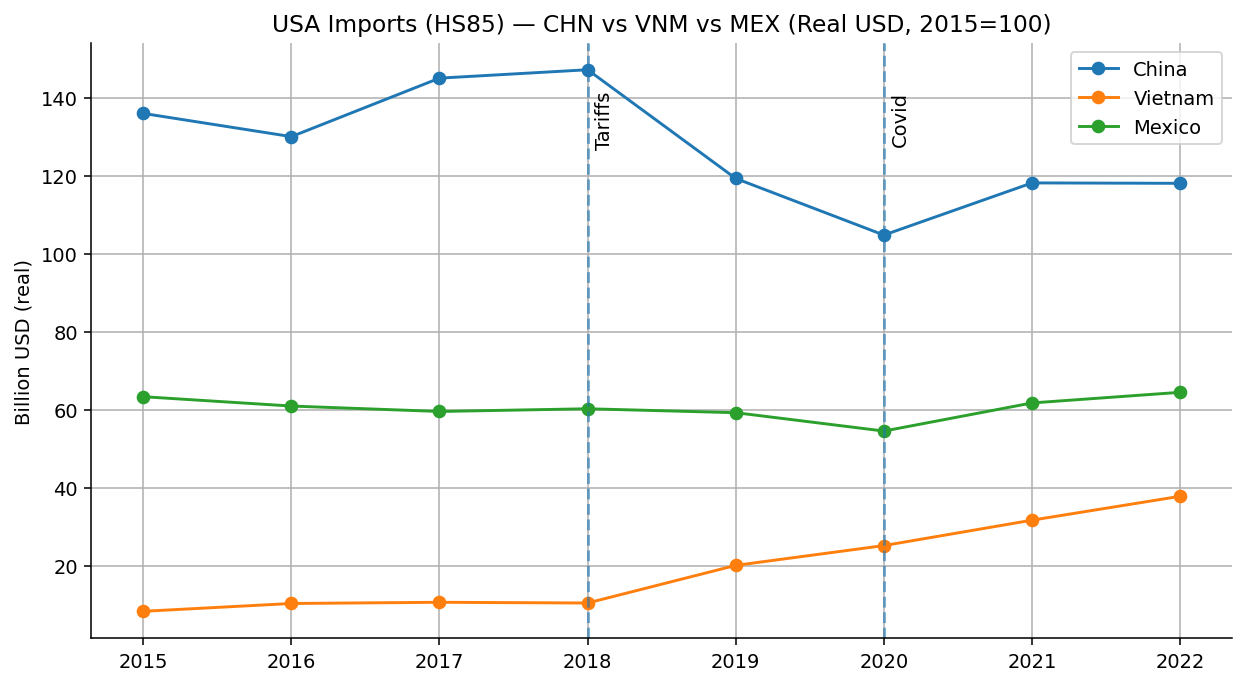

Saved figure: figures/part3_figA_usa_hs85_trio.png


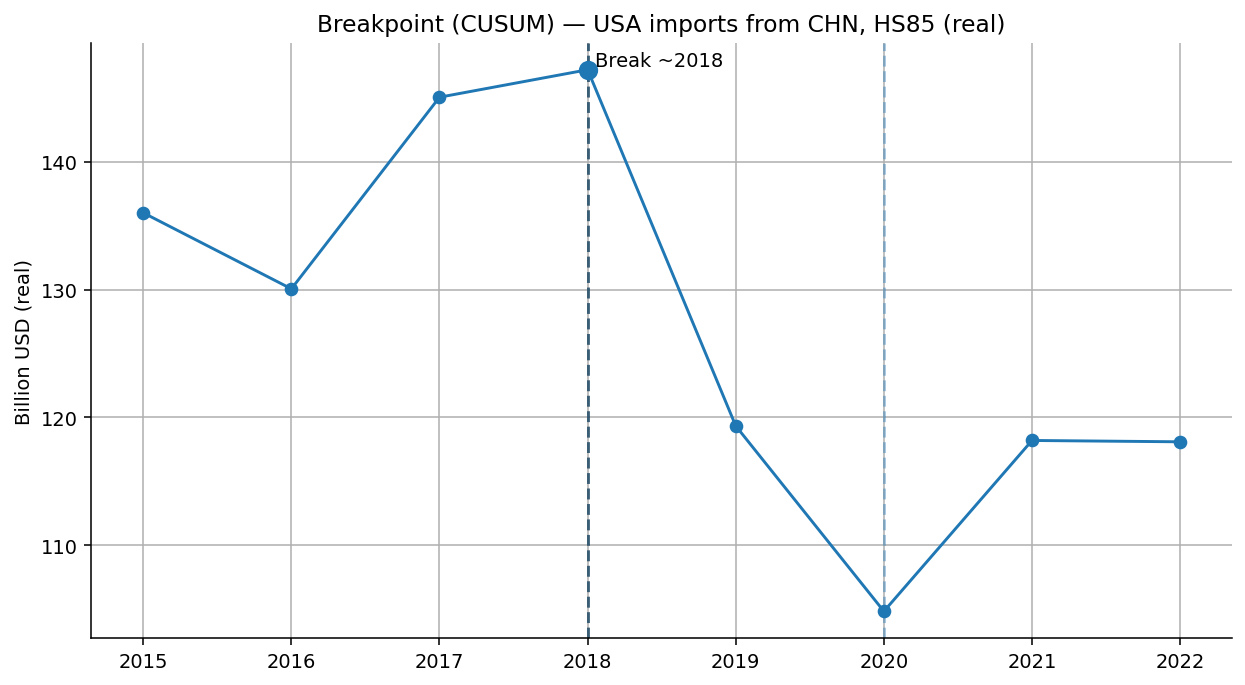

Saved figure: figures/part3_figB_break_USA_CHN_HS85_import.png


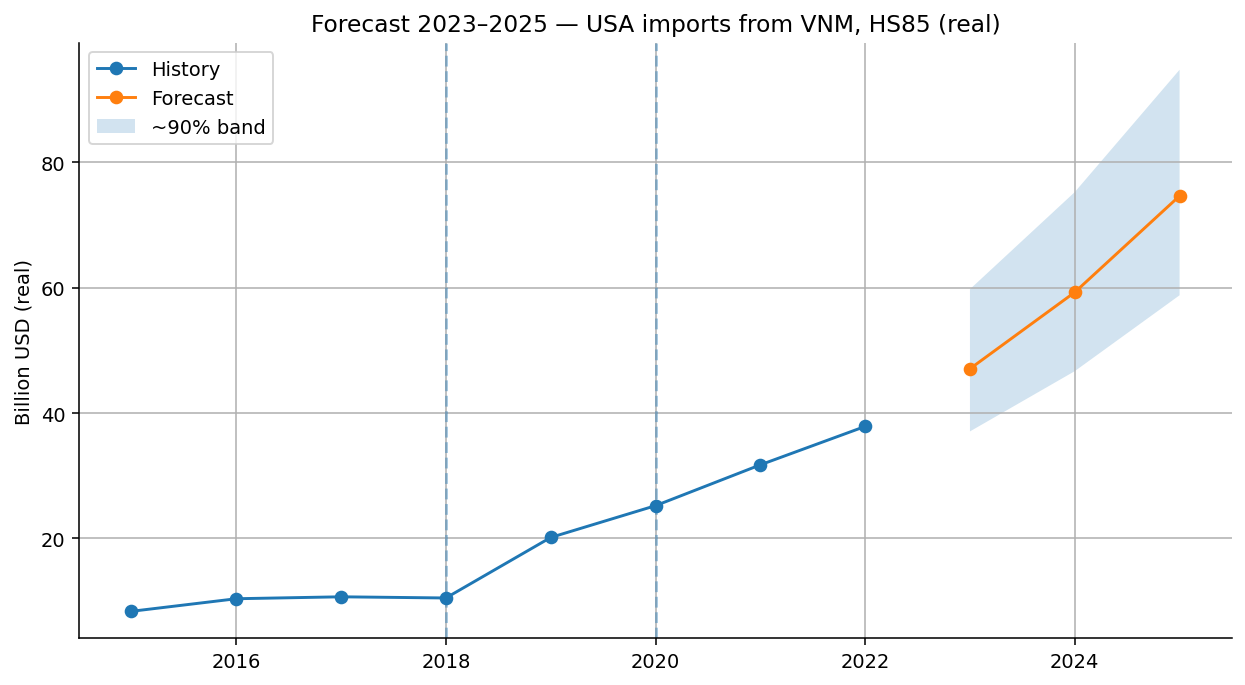

Saved figure: figures/part3_figC_forecast_USA_VNM_HS85_import.png


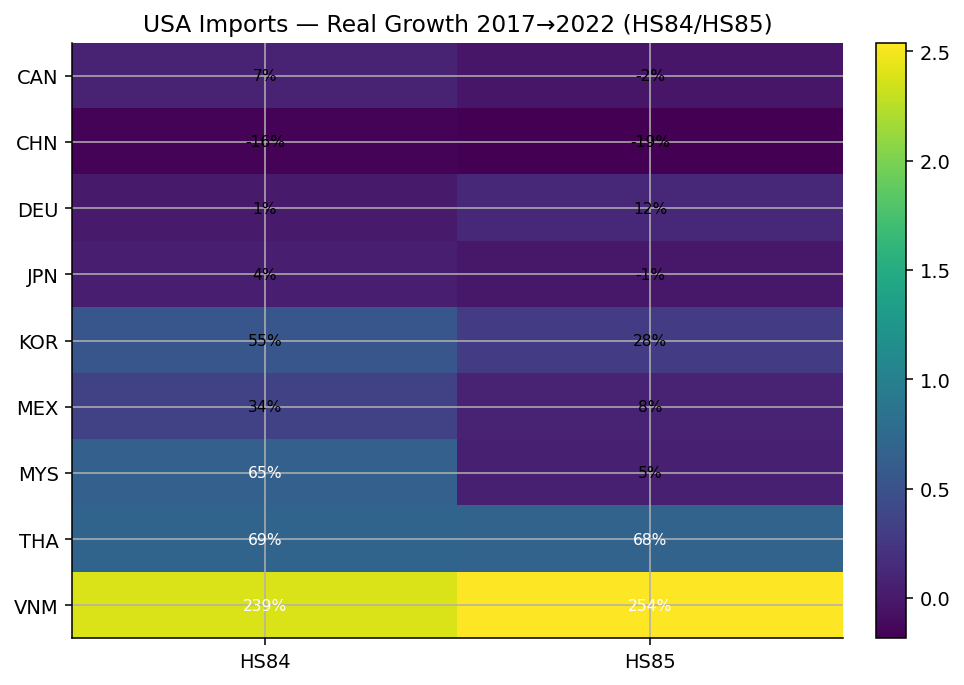

Saved figure: figures/part3_figD_heatmap_growth_usa_hs84_85.png
Saved table: reports/tables/part3_heatmap_growth_table.csv

✅ Part 3 summary ready. See the FIGURES and TABLES folders for saved assets.


In [29]:
# [S] PART 3 — SUMMARY TABLES & FIGURES FOR THE PAPER
# ===================================================
# This cell builds CPI-deflated series, finds structural breaks (CUSUM),
# produces simple log-linear forecasts (2023–2025), and outputs a compact
# set of tables & figures ready for your paper.

# 0) Imports & paths --------------------------------------------------------
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

# Reuse ROOT/FIGURES/TABLES if they exist, otherwise reconstruct defaults
try:
    ROOT
except NameError:
    # Fallback if cell is run standalone
    ROOT = Path("/content/drive/MyDrive/TradeWar/latest")
DATA_PROC = ROOT / "data" / "processed"
FIGURES   = ROOT / "figures"
TABLES    = ROOT / "reports" / "tables"
for p in [FIGURES, TABLES]:
    p.mkdir(parents=True, exist_ok=True)

# 1) Load data if not already in memory ------------------------------------
def _parquet(name: str) -> Path:
    p = DATA_PROC / name
    if p.exists(): return p
    # search anywhere under ROOT
    hits = list(ROOT.rglob(name))
    if hits: return hits[0]
    raise FileNotFoundError(f"Missing parquet: {name} under {DATA_PROC} or {ROOT}")

try:
    df_trade
except NameError:
    df_trade = pd.read_parquet(_parquet("trade_bilateral_by_hs2.parquet"))

try:
    wb
except NameError:
    wb = pd.read_parquet(_parquet("world_bank_indicators.parquet"))

# Keep 11 focus countries only (drop aggregates)
countries = ["USA","CHN","VNM","MEX","DEU","JPN","KOR","CAN","TWN","THA","MYS"]
df_trade = df_trade[df_trade["reporter"].isin(countries) & df_trade["partner"].isin(countries)].copy()

# 2) CPI deflator (base 2015=100) ------------------------------------------
BASE_YEAR = 2015
cpi = wb[wb["indicator"].eq("FP.CPI.TOTL")][["country","year","value"]].copy()
cpi = cpi.pivot(index="year", columns="country", values="value")
cpi = cpi.divide(cpi.loc[BASE_YEAR], axis=1) * 100.0

def deflate_by_reporter(df: pd.DataFrame, out_col="real_trade_value_usd") -> pd.DataFrame:
    d = df.copy()
    vals = []
    for yr, rep, val in zip(d["year"], d["reporter"], d["trade_value_usd"]):
        f = np.nan
        if rep in cpi.columns and yr in cpi.index:
            f = cpi.loc[yr, rep] / 100.0  # 2015=1 if CPI exists
        vals.append(val / f if np.isfinite(f) and f > 0 else val)
    d[out_col] = vals
    return d

df_real = deflate_by_reporter(df_trade)

# 3) Helper: extract a tidy series for a specific (reporter,partner,hs2,flow)
def get_series(df: pd.DataFrame, reporter, partner, hs2, flow):
    s = (df.query("reporter==@reporter and partner==@partner and hs2==@hs2 and flow==@flow")
           .sort_values("year")[["year","real_trade_value_usd"]].dropna())
    s = s.groupby("year", as_index=False).sum()  # guard for duplicates
    s["log_real"] = np.log1p(s["real_trade_value_usd"])
    return s

# 4) Simple CUSUM breakpoint (one break) ------------------------------------
def cusum_break_year(y: np.ndarray, years: np.ndarray) -> tuple[int|None, float]:
    """
    Return (break_year, score). Score = max |standardized CUSUM|.
    If length < 6 or flat series, returns (None, 0).
    """
    y = np.asarray(y, float)
    n = len(y)
    if n < 6 or np.allclose(y, y[0]):
        return None, 0.0
    z = (y - y.mean()) / (y.std(ddof=1) if y.std(ddof=1) > 0 else 1.0)
    cus = np.cumsum(z)
    k = np.argmax(np.abs(cus))
    score = float(np.abs(cus[k]) / np.sqrt(n))
    # Avoid endpoints
    if k == 0 or k == n-1:
        return None, 0.0
    return int(years[k]), score

# 5) Simple log-linear forecast (2023–2025) ---------------------------------
def loglinear_forecast(s: pd.DataFrame, steps=3) -> pd.DataFrame:
    """
    Fit log(1+real) ~ a + b*year on 2015–2022, forecast next 'steps' years.
    Bands = +/- 1.64*std(resid) on log-scale (≈ 90% PI), back-transform.
    """
    df = s.copy()
    x = df["year"].values.astype(float)
    y = df["log_real"].values.astype(float)
    # fit a + b*x
    b, a = np.polyfit(x, y, deg=1)
    yhat = a + b*x
    resid = y - yhat
    s_res = float(np.sqrt((resid**2).mean()))
    # forecast years
    yf = np.arange(df["year"].max()+1, df["year"].max()+1+steps, dtype=int)
    pred = a + b*yf
    lo = pred - 1.64*s_res
    hi = pred + 1.64*s_res
    out = pd.DataFrame({
        "year": yf,
        "log_pred": pred,
        "log_lo": lo,
        "log_hi": hi
    })
    for col_in, col_out in [("log_pred","pred"),("log_lo","lo"),("log_hi","hi")]:
        out[col_out] = np.expm1(out[col_in].values)
    return out[["year","pred","lo","hi"]]

# 6) Targets to show in the paper -------------------------------------------
TARGETS = [
    # (reporter, partner, hs2, flow)
    ("USA","CHN","85","import"),
    ("USA","VNM","85","import"),
    ("USA","MEX","85","import"),
    ("USA","CHN","84","import"),
]

# 7) Build breakpoints & forecasts tables -----------------------------------
bp_rows, fc_rows = [], []
for rep, par, hs, fl in TARGETS:
    ser = get_series(df_real, rep, par, hs, fl)
    by, score = cusum_break_year(ser["log_real"].values, ser["year"].values)
    bp_rows.append({"reporter":rep,"partner":par,"hs2":hs,"flow":fl,
                    "break_year":by, "cusum_score":round(score,3)})
    fc = loglinear_forecast(ser, steps=3)
    fc["reporter"], fc["partner"], fc["hs2"], fc["flow"] = rep, par, hs, fl
    fc_rows.append(fc)

bp_table = pd.DataFrame(bp_rows)
fc_table = pd.concat(fc_rows, ignore_index=True)

bp_path = (TABLES / "part3_breakpoints_summary.csv")
fc_path = (TABLES / "part3_forecasts_summary.csv")
bp_table.to_csv(bp_path, index=False)
fc_table.to_csv(fc_path, index=False)

print("Saved tables:")
print(" •", bp_path.relative_to(ROOT))
print(" •", fc_path.relative_to(ROOT))

display(bp_table)
display(fc_table.head(12))

# 8) Figure A: USA HS85 imports from CHN vs VNM vs MEX ----------------------
def plot_us_hs85_trio():
    plt.figure()
    trio = [("CHN","China"),("VNM","Vietnam"),("MEX","Mexico")]
    for code, label in trio:
        s = get_series(df_real, "USA", code, "85", "import")
        plt.plot(s["year"], s["real_trade_value_usd"]/1e9, marker="o", label=label)
    for vline, lab in [(2018,"Tariffs"), (2020,"Covid")]:
        plt.axvline(vline, linestyle="--", alpha=0.6)
        plt.text(vline+0.05, plt.ylim()[1]*0.92, lab, rotation=90, va="top", ha="left")
    plt.title("USA Imports (HS85) — CHN vs VNM vs MEX (Real USD, 2015=100)")
    plt.ylabel("Billion USD (real)")
    plt.legend()
    out = FIGURES / "part3_figA_usa_hs85_trio.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
    print("Saved figure:", out.relative_to(ROOT))

plot_us_hs85_trio()

# 9) Figure B: Example breakpoints overlay (USA–CHN, HS85, imports) ---------
def plot_break_example(rep="USA", par="CHN", hs="85", fl="import"):
    s = get_series(df_real, rep, par, hs, fl)
    by, score = cusum_break_year(s["log_real"].values, s["year"].values)
    plt.figure()
    plt.plot(s["year"], s["real_trade_value_usd"]/1e9, marker="o", label=f"{rep}->{par}")
    if by is not None:
        y_at = float((s.loc[s["year"].eq(by), "real_trade_value_usd"]/1e9).values[0])
        plt.axvline(by, color="k", linestyle="--", alpha=0.6)
        plt.scatter([by],[y_at], s=80, zorder=5)
        plt.text(by+0.05, y_at, f"Break ~{by}", va="bottom", ha="left")
    for vline, lab in [(2018,"Tariffs"), (2020,"Covid")]:
        plt.axvline(vline, linestyle="--", alpha=0.4)
    plt.title(f"Breakpoint (CUSUM) — {rep} imports from {par}, HS{hs} (real)")
    plt.ylabel("Billion USD (real)")
    out = FIGURES / f"part3_figB_break_{rep}_{par}_HS{hs}_{fl}.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
    print("Saved figure:", out.relative_to(ROOT))

plot_break_example()

# 10) Figure C: Forecast fan chart (USA–VNM, HS85, imports) -----------------
def plot_forecast_example(rep="USA", par="VNM", hs="85", fl="import"):
    s = get_series(df_real, rep, par, hs, fl)
    fc = loglinear_forecast(s, steps=3)
    plt.figure()
    plt.plot(s["year"], s["real_trade_value_usd"]/1e9, marker="o", label="History")
    plt.plot(fc["year"], fc["pred"]/1e9, marker="o", label="Forecast")
    plt.fill_between(fc["year"], fc["lo"]/1e9, fc["hi"]/1e9, alpha=0.2, label="~90% band")
    for vline, lab in [(2018,"Tariffs"), (2020,"Covid")]:
        plt.axvline(vline, linestyle="--", alpha=0.4)
    ttl = f"Forecast 2023–2025 — {rep} imports from {par}, HS{hs} (real)"
    plt.title(ttl)
    plt.ylabel("Billion USD (real)")
    plt.legend()
    out = FIGURES / f"part3_figC_forecast_{rep}_{par}_HS{hs}_{fl}.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
    print("Saved figure:", out.relative_to(ROOT))

plot_forecast_example()

# 11) Figure D: Heatmap of 2017→2022 growth (USA imports, HS84/HS85) -------
def plot_heatmap_growth():
    # pivot: index partner, columns hs, value = growth 2017->2022 (real)
    out_rows = []
    for hs in ["84","85"]:
        for par in countries:
            if par == "USA":
                continue
            s = get_series(df_real, "USA", par, hs, "import")
            if 2017 in s["year"].values and 2022 in s["year"].values:
                v0 = float(s.loc[s["year"].eq(2017), "real_trade_value_usd"])
                v1 = float(s.loc[s["year"].eq(2022), "real_trade_value_usd"])
                g  = (v1 - v0) / v0 if v0 > 0 else np.nan
                out_rows.append({"partner":par, "hs2":hs, "growth_17_22":g})
    H = pd.DataFrame(out_rows).pivot(index="partner", columns="hs2", values="growth_17_22")
    # plot without seaborn
    plt.figure(figsize=(7,5))
    im = plt.imshow(H.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(H.shape[1]), labels=[f"HS{c}" for c in H.columns])
    plt.yticks(ticks=np.arange(H.shape[0]), labels=H.index)
    plt.title("USA Imports — Real Growth 2017→2022 (HS84/HS85)")
    # annotate
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            val = H.values[i,j]
            if np.isfinite(val):
                plt.text(j, i, f"{val*100:,.0f}%", ha="center", va="center", fontsize=8, color="white" if abs(val)>0.6 else "black")
    out = FIGURES / "part3_figD_heatmap_growth_usa_hs84_85.png"
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
    print("Saved figure:", out.relative_to(ROOT))
    # also save numeric table
    H.to_csv(TABLES / "part3_heatmap_growth_table.csv")
    print("Saved table:", (TABLES / "part3_heatmap_growth_table.csv").relative_to(ROOT))

plot_heatmap_growth()

print("\n✅ Part 3 summary ready. See the FIGURES and TABLES folders for saved assets.")

## 4) Environmental Impact (Shipping Distance & CO₂)

In [30]:
# [0] IMPORTS & GLOBAL CONFIG (ENV IMPACT: DISTANCE & CO2)
# ========================================================

from pathlib import Path
import os, glob, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

# Focus countries (same as in Parts 2–3)
COUNTRIES = ["USA","CHN","VNM","MEX","DEU","JPN","KOR","CAN","TWN","THA","MYS"]
YEARS = list(range(2015, 2023))

# --- Ports (approx.) per country: single representative container port
#     NOTE: This is an approximation for long-run comparisons.
PORTS = {
    "USA": (33.75, -118.20),  # Los Angeles / Long Beach
    "CHN": (31.40, 121.80),   # Shanghai
    "VNM": (10.78, 106.73),   # Ho Chi Minh City (Cat Lai)
    "MEX": (19.05, -104.32),  # Manzanillo
    "DEU": (53.54, 9.99),     # Hamburg
    "JPN": (35.45, 139.65),   # Yokohama
    "KOR": (35.10, 129.04),   # Busan
    "CAN": (49.30, -123.12),  # Vancouver
    "TWN": (22.62, 120.30),   # Kaohsiung
    "THA": (13.09, 100.89),   # Laem Chabang
    "MYS": (3.00, 101.40),    # Port Klang
}

# --- Sea-route detour factor:
#     Real sea-lanes are typically longer than great-circle routes due to canals/straits.
SEA_ROUTE_MULT = 1.20  # conservative 20% detour vs. great-circle

# --- Value-to-Mass coefficients (tonnes per $1,000) by HS2
#     Baseline reflects typical value density: HS84 (machinery) denser than HS85 (electronics).
TONNES_PER_1K_USD = {
    "84": 0.10,   # 0.10 t per $1,000  (≈ $10/kg)
    "85": 0.03,   # 0.03 t per $1,000  (≈ $33/kg)
}

# --- Emission factor for container shipping (gCO2 per tonne-km)
EF_G_PER_TKM = 15.0  # baseline; sensitivity will vary this ±40%

# --- Whether to count both import and export flows (True) or just imports (False)
USE_BOTH_FLOWS = True

In [31]:
# [1] SAFE MOUNT + LOAD CORE PARQUETS (REUSE FROM PARTS 2–3)
# ==========================================================
# Robust mount (Colab), target: /content/gdrive/MyDrive/TradeWar/latest
# Auto-fallback: search for the required parquet if the canonical path is missing.

from google.colab import drive

def _safe_mount():
    MOUNT = "/content/gdrive"
    try:
        drive.mount(MOUNT, force_remount=False)
    except Exception as e:
        # If "mountpoint must not already contain files" happens, try a different mount path
        print("⚠️ Primary mount failed:", e)
        try:
            drive.mount(MOUNT, force_remount=True)
        except Exception as e2:
            print("⚠️ Primary remount failed:", e2)
            ALT = "/content/gdrive_alt"
            drive.mount(ALT, force_remount=True)
            return Path(ALT)
    return Path(MOUNT)

MOUNT_ROOT = _safe_mount()
DRIVE_ROOT = MOUNT_ROOT / "MyDrive" / "TradeWar" / "latest"
DATA_PROC  = DRIVE_ROOT / "data" / "processed"
FIGURES    = DRIVE_ROOT / "figures"
TABLES     = DRIVE_ROOT / "reports" / "tables"
for p in [FIGURES, TABLES]:
    p.mkdir(parents=True, exist_ok=True)

REQ = {
    "trade": DATA_PROC / "trade_bilateral_by_hs2.parquet"
}

def _autolocate(name: str, root: Path) -> Path:
    # search anywhere under TradeWar for the filename
    hits = list(root.glob(f"**/{name}"))
    return hits[0] if hits else None

# Load trade parquet (created in Part 2)
p_trade = REQ["trade"] if REQ["trade"].exists() else _autolocate("trade_bilateral_by_hs2.parquet", DRIVE_ROOT)
if p_trade is None or not p_trade.exists():
    raise FileNotFoundError(
        f"Missing parquet: trade_bilateral_by_hs2.parquet under {DATA_PROC} or elsewhere in {DRIVE_ROOT}"
    )

df_trade = pd.read_parquet(p_trade)
df_trade = df_trade[
    df_trade["reporter"].isin(COUNTRIES) & df_trade["partner"].isin(COUNTRIES)
]
df_trade = df_trade[df_trade["year"].isin(YEARS)]

print("[ROOT]", DRIVE_ROOT)
print("Trade loaded →", p_trade.relative_to(DRIVE_ROOT))
print(df_trade.head(3))
print("Shape:", df_trade.shape, "| Years:", sorted(df_trade["year"].unique()))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[ROOT] /content/gdrive/MyDrive/TradeWar/latest
Trade loaded → data/processed/trade_bilateral_by_hs2.parquet
   year reporter partner hs2    flow  trade_value_usd
0  2015      USA     CHN  84  import     1.070321e+11
1  2015      USA     CHN  84  export     1.224813e+10
2  2015      USA     CHN  85  import     1.360062e+11
Shape: (2880, 6) | Years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


Distance sample:
   reporter partner         gc_km        sea_km
0      USA     CHN  10424.476224  12509.371469
1      USA     VNM  13156.304577  15787.565493
2      USA     MEX   2136.062195   2563.274634
3      USA     DEU   9104.083400  10924.900080
4      USA     JPN   8856.648342  10627.978010


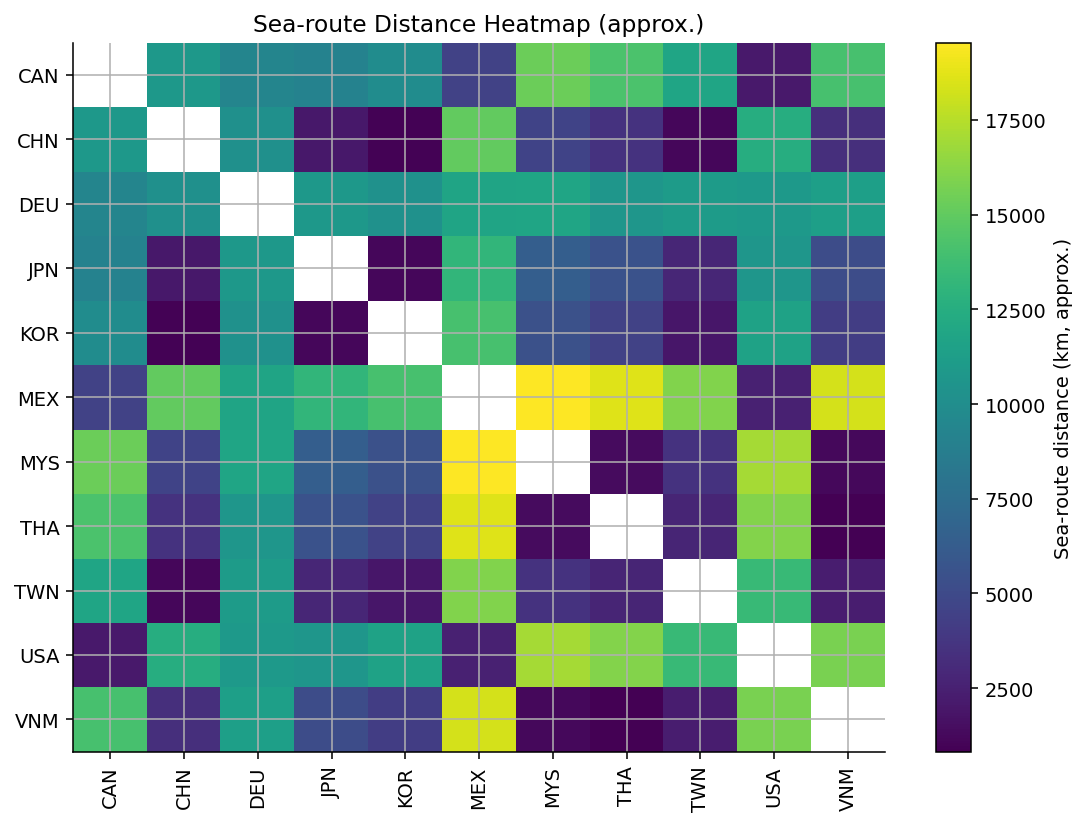

In [32]:
# [2] DISTANCE ENGINE: HAVERSINE + SEA-ROUTE MULTIPLIER
# =====================================================

def haversine_km(lat1, lon1, lat2, lon2):
    """Great-circle distance (km) between two points."""
    R = 6371.0088  # Earth mean radius (km)
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# Build a reporter→partner distance table
rows = []
for r, p in itertools.permutations(COUNTRIES, 2):
    lat_r, lon_r = PORTS[r]
    lat_p, lon_p = PORTS[p]
    gc = haversine_km(lat_r, lon_r, lat_p, lon_p)
    sea = gc * SEA_ROUTE_MULT
    rows.append((r, p, gc, sea))

df_dist = pd.DataFrame(rows, columns=["reporter","partner","gc_km","sea_km"])
print("Distance sample:\n", df_dist.head(5))

# Save (optional)
df_dist.to_csv((TABLES / "part4_distances_gc_sea.csv"), index=False)

# Quick distance heatmap (for intuition)
mat = df_dist.pivot(index="reporter", columns="partner", values="sea_km")
plt.figure(figsize=(8,6))
plt.imshow(mat.values, aspect="auto")
plt.colorbar(label="Sea-route distance (km, approx.)")
plt.xticks(ticks=range(len(mat.columns)), labels=mat.columns, rotation=90)
plt.yticks(ticks=range(len(mat.index)), labels=mat.index)
plt.title("Sea-route Distance Heatmap (approx.)")
plt.tight_layout()
plt.savefig(FIGURES / "part4_distance_heatmap.png", dpi=160)
plt.show()

In [33]:
# [3] MASS & CO2 CALCULATOR (BASELINE)
# ====================================
# We estimate shipment mass from trade VALUE using HS-specific value density.
# Then CO2 = tonnes * distance_km * EF_g_per_tkm / 1e6  (→ tonnes CO2)

def value_to_tonnes(trade_value_usd: float, hs2: str,
                    tonnes_per_1k: dict = TONNES_PER_1K_USD) -> float:
    coef = tonnes_per_1k.get(hs2, np.nan)
    return (trade_value_usd / 1000.0) * coef

def co2_tonnes(tonnes: float, distance_km: float, ef_g_per_tkm: float = EF_G_PER_TKM) -> float:
    return tonnes * distance_km * ef_g_per_tkm / 1e6

# Attach distances to trade, compute tonnes + CO2 (baseline)
df_env = df_trade.merge(df_dist[["reporter","partner","sea_km"]], on=["reporter","partner"], how="left")
df_env["tonnes_est"] = df_env.apply(lambda r: value_to_tonnes(r["trade_value_usd"], r["hs2"]), axis=1)
df_env["co2_tonnes"] = df_env.apply(lambda r: co2_tonnes(r["tonnes_est"], r["sea_km"]), axis=1)

# Option: count imports only to avoid double-counting legs
if not USE_BOTH_FLOWS:
    df_env = df_env[df_env["flow"] == "import"].copy()

# Basic sanity
print("ENV columns:", df_env.columns.tolist())
print("ENV shape:", df_env.shape)
df_env.head(3)

ENV columns: ['year', 'reporter', 'partner', 'hs2', 'flow', 'trade_value_usd', 'sea_km', 'tonnes_est', 'co2_tonnes']
ENV shape: (2880, 9)


,year,reporter,partner,hs2,flow,trade_value_usd,sea_km,tonnes_est,co2_tonnes
0,2015,USA,CHN,84,import,1.070321e+11,12509.371469,1.070321e+07,2.008357e+06
1,2015,USA,CHN,84,export,1.224813e+10,12509.371469,1.224813e+06,2.298246e+05
2,2015,USA,CHN,85,import,1.360062e+11,12509.371469,4.080186e+06,7.656085e+05


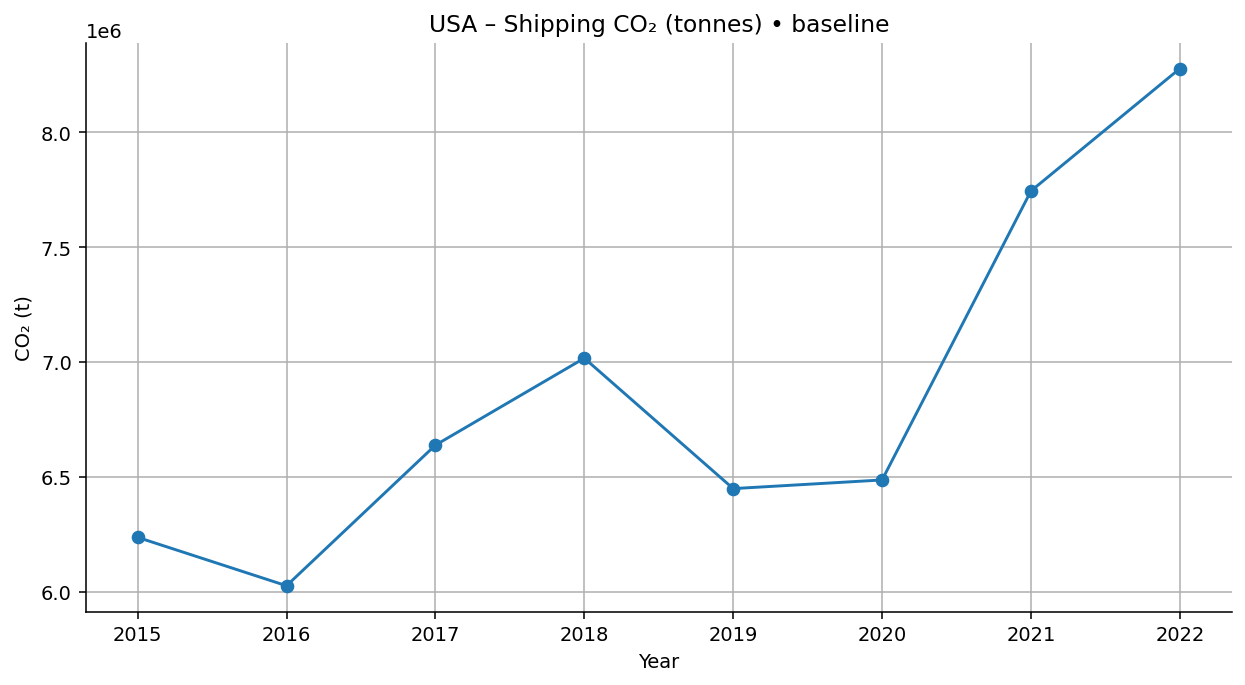

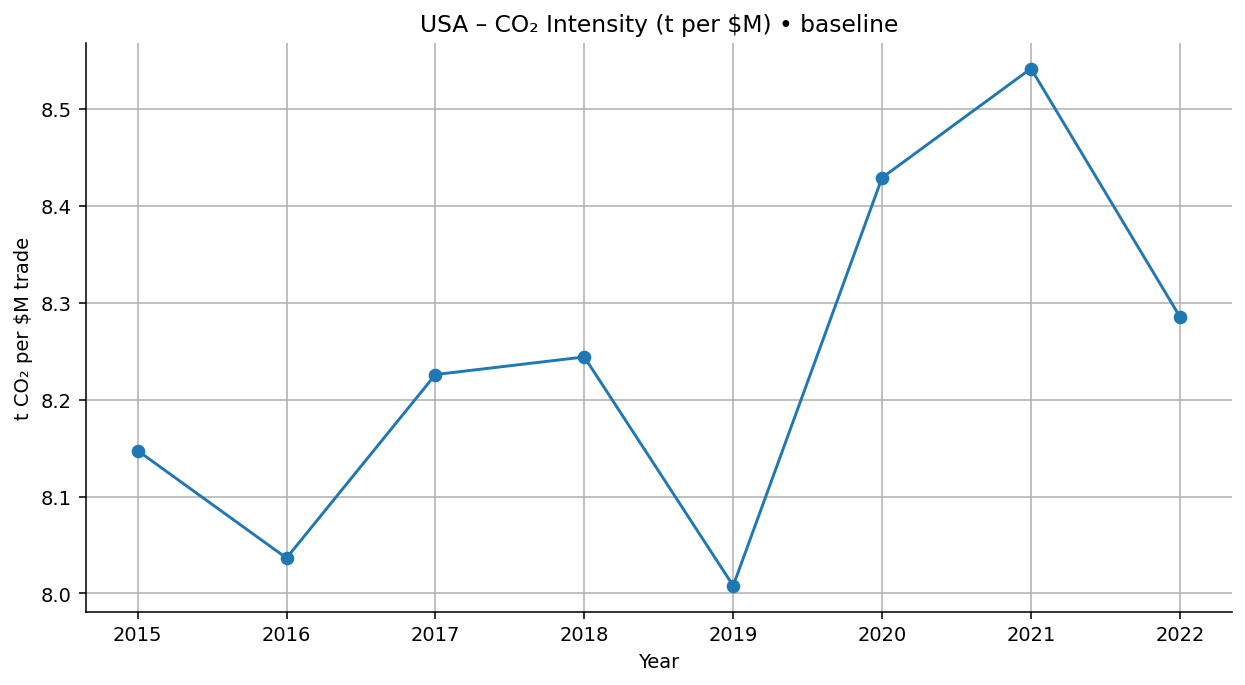

In [34]:
# [4] YEARLY & ROUTE AGGREGATES + INTENSITY
# =========================================

# 4.1) Yearly totals by reporter (tonnes CO2)
co2_by_year_reporter = (
    df_env.groupby(["year","reporter"], as_index=False)["co2_tonnes"].sum()
    .sort_values(["reporter","year"])
)
co2_by_year_reporter.to_csv(TABLES / "part4_co2_by_year_reporter.csv", index=False)

# 4.2) Route totals (for comparisons, e.g., re-routing)
co2_by_route_year = (
    df_env.groupby(["year","reporter","partner"], as_index=False)["co2_tonnes"].sum()
)
co2_by_route_year.to_csv(TABLES / "part4_co2_by_route_year.csv", index=False)

# 4.3) CO2 intensity per trade value
tmp = df_env.groupby(["year","reporter"], as_index=False).agg(
    co2_tonnes=("co2_tonnes","sum"),
    value_usd=("trade_value_usd","sum")
)
tmp["co2_per_musd"] = tmp["co2_tonnes"] / (tmp["value_usd"]/1e6)
tmp.to_csv(TABLES / "part4_co2_intensity_by_reporter.csv", index=False)

# Plot: USA imports CO2 timeseries (example)
usa_imp = (df_env[df_env["reporter"]=="USA"]
           .groupby("year", as_index=False)["co2_tonnes"].sum())
plt.plot(usa_imp["year"], usa_imp["co2_tonnes"], marker="o")
plt.title("USA – Shipping CO₂ (tonnes) • baseline")
plt.xlabel("Year"); plt.ylabel("CO₂ (t)")
plt.tight_layout()
plt.savefig(FIGURES / "part4_usa_co2_timeseries.png", dpi=160)
plt.show()

# Plot: CO2 intensity for USA (t per $M)
usa_int = tmp[tmp["reporter"]=="USA"].copy()
plt.plot(usa_int["year"], usa_int["co2_per_musd"], marker="o")
plt.title("USA – CO₂ Intensity (t per $M) • baseline")
plt.xlabel("Year"); plt.ylabel("t CO₂ per $M trade")
plt.tight_layout()
plt.savefig(FIGURES / "part4_usa_co2_intensity.png", dpi=160)
plt.show()

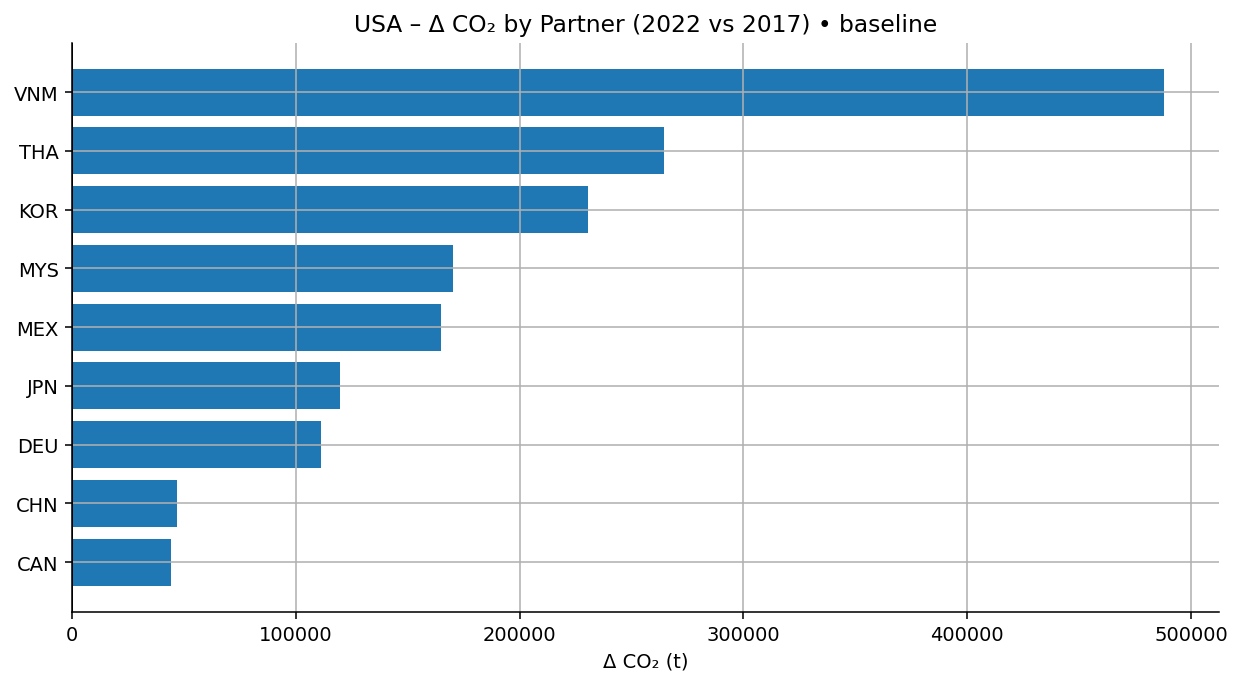

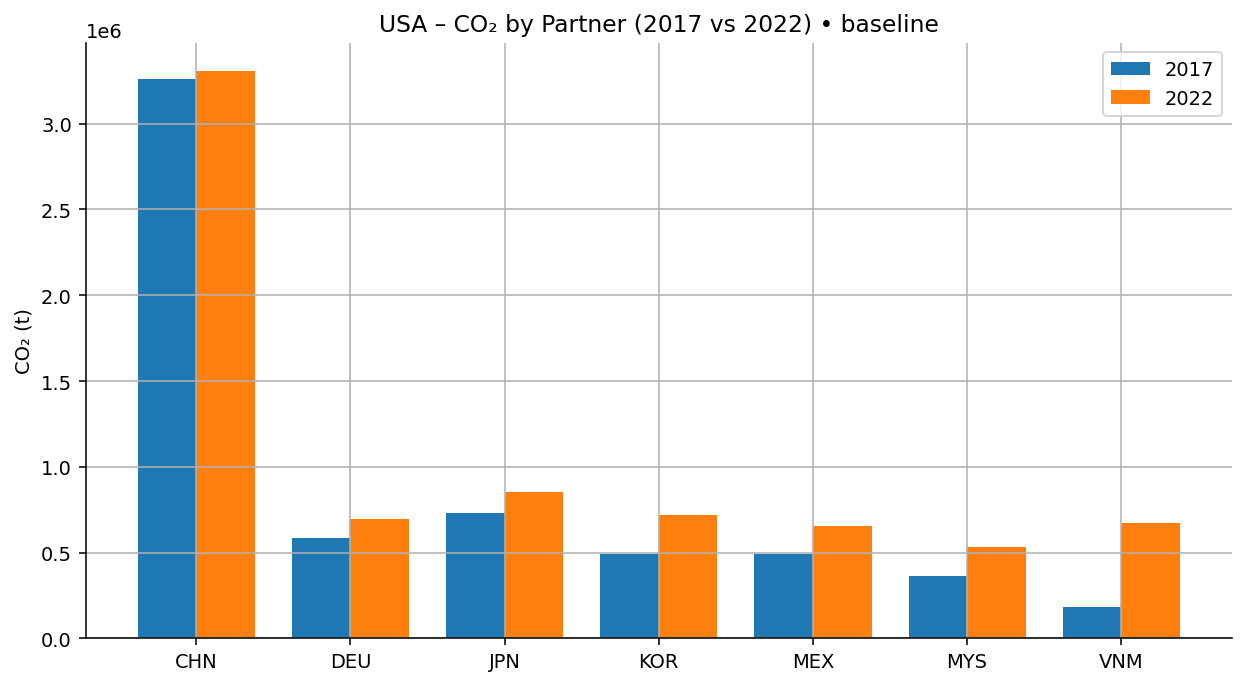

In [35]:
# [5] REROUTING VIEW: 2017 vs 2022 (EXAMPLE: USA IMPORTS)
# =======================================================
# Show how partner mix shift affected CO₂ (distance-weighted mass).

panel = (df_env[(df_env["reporter"]=="USA")].copy())
base = panel[panel["year"]==2017].groupby("partner", as_index=False)["co2_tonnes"].sum()
curr = panel[panel["year"]==2022].groupby("partner", as_index=False)["co2_tonnes"].sum()

diff = base.merge(curr, on="partner", how="outer", suffixes=("_2017","_2022")).fillna(0.0)
diff["delta"] = diff["co2_tonnes_2022"] - diff["co2_tonnes_2017"]
diff_sorted = diff.sort_values("delta", ascending=True)
diff_sorted.to_csv(TABLES / "part4_usa_co2_partner_delta_2017_2022.csv", index=False)

# Bar: which partners drove the CO2 change
plt.barh(diff_sorted["partner"], diff_sorted["delta"])
plt.axvline(0, color="k", linewidth=1)
plt.title("USA – Δ CO₂ by Partner (2022 vs 2017) • baseline")
plt.xlabel("Δ CO₂ (t)")
plt.tight_layout()
plt.savefig(FIGURES / "part4_usa_co2_delta_2017_2022.png", dpi=160)
plt.show()

# Complement: compare levels in 2017 vs 2022 for top partners
top_partners = (curr.sort_values("co2_tonnes", ascending=False).head(6)["partner"].tolist() +
                base.sort_values("co2_tonnes", ascending=False).head(6)["partner"].tolist())
top_partners = sorted(list(set(top_partners)))

subset = diff[diff["partner"].isin(top_partners)].copy()
subset = subset.sort_values("partner")
X = np.arange(len(subset))
w = 0.38
plt.bar(X - w/2, subset["co2_tonnes_2017"], width=w, label="2017")
plt.bar(X + w/2, subset["co2_tonnes_2022"], width=w, label="2022")
plt.xticks(X, subset["partner"])
plt.ylabel("CO₂ (t)")
plt.title("USA – CO₂ by Partner (2017 vs 2022) • baseline")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "part4_usa_co2_2017_vs_2022.png", dpi=160)
plt.show()

  scenario  USA_2022_co2_tonnes
0      LOW         2.483228e+06
1     BASE         8.277428e+06
2     HIGH         1.738260e+07


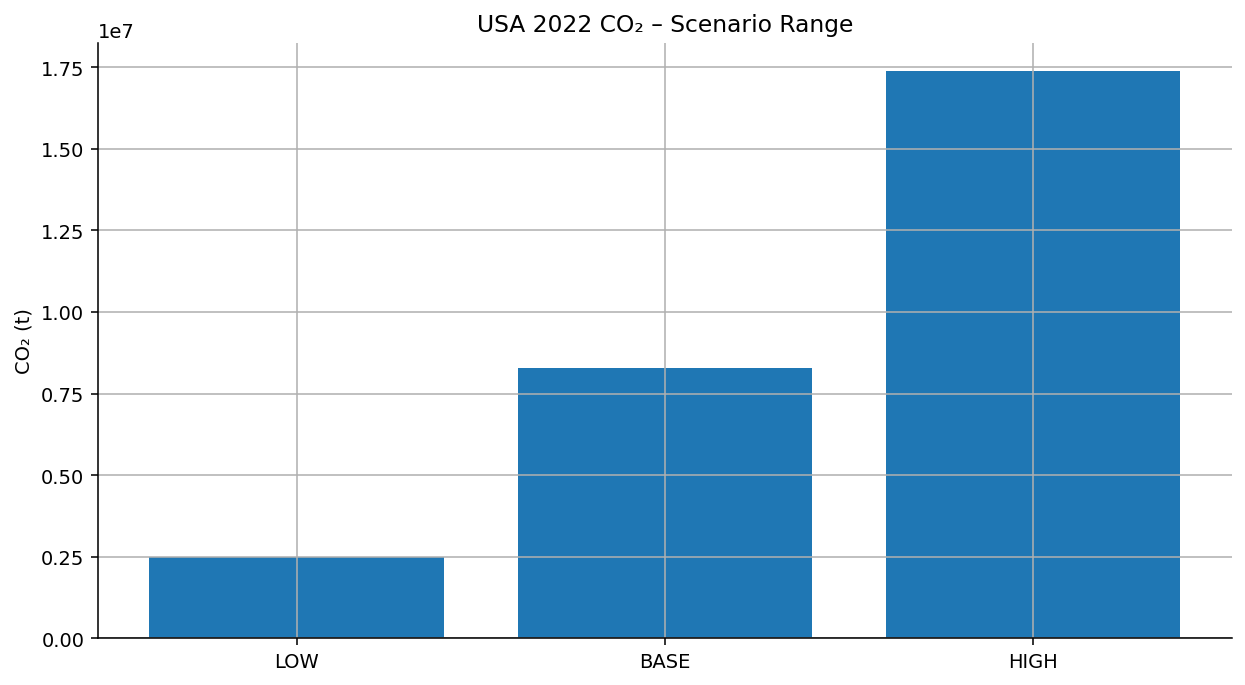

In [36]:
# [6] SCENARIO & SENSITIVITY (LOW / BASE / HIGH)
# ==============================================
# Sensitivity 1: value→mass coefficients ±50%
# Sensitivity 2: emission factor ±40%

SCENARIOS = {
    "LOW":  {"tonnes_per_1k": {"84": TONNES_PER_1K_USD["84"]*0.5, "85": TONNES_PER_1K_USD["85"]*0.5},
             "ef": EF_G_PER_TKM*0.6},
    "BASE": {"tonnes_per_1k": TONNES_PER_1K_USD, "ef": EF_G_PER_TKM},
    "HIGH": {"tonnes_per_1k": {"84": TONNES_PER_1K_USD["84"]*1.5, "85": TONNES_PER_1K_USD["85"]*1.5},
             "ef": EF_G_PER_TKM*1.4},
}

def compute_co2_for_scenario(df, tonnes_per_1k: dict, ef: float):
    out = df.copy()
    out["tonnes_est"] = out.apply(lambda r: value_to_tonnes(r["trade_value_usd"], r["hs2"], tonnes_per_1k), axis=1)
    out["co2_tonnes"] = out.apply(lambda r: co2_tonnes(r["tonnes_est"], r["sea_km"], ef), axis=1)
    return out

# Example: USA total CO2 in 2022 under three scenarios
rows = []
for name, prm in SCENARIOS.items():
    tmp = compute_co2_for_scenario(df_env, prm["tonnes_per_1k"], prm["ef"])
    if not USE_BOTH_FLOWS:
        tmp = tmp[tmp["flow"]=="import"]
    usa22 = tmp[(tmp["reporter"]=="USA") & (tmp["year"]==2022)]["co2_tonnes"].sum()
    rows.append((name, usa22))
sens = pd.DataFrame(rows, columns=["scenario","USA_2022_co2_tonnes"])
sens.to_csv(TABLES / "part4_sensitivity_usa_2022.csv", index=False)
print(sens)

# Quick bar
plt.bar(sens["scenario"], sens["USA_2022_co2_tonnes"])
plt.title("USA 2022 CO₂ – Scenario Range")
plt.ylabel("CO₂ (t)")
plt.tight_layout()
plt.savefig(FIGURES / "part4_sensitivity_usa2022.png", dpi=160)
plt.show()


CO₂ by Year & Reporter (head)


,year,reporter,co2_tonnes
0,2015,CAN,6.487829e+05
1,2016,CAN,6.490470e+05
2,2017,CAN,6.642474e+05
3,2018,CAN,7.165260e+05
4,2019,CAN,7.039949e+05
5,2020,CAN,6.514664e+05
6,2021,CAN,7.733091e+05
7,2022,CAN,8.344676e+05
8,2015,CHN,4.183002e+06
9,2016,CHN,3.947062e+06



CO₂ Intensity by Reporter (t per $M, head)


,year,reporter,co2_tonnes,value_usd,co2_per_musd
0,2015,CAN,6.487829e+05,1.266809e+11,5.121393
1,2015,CHN,4.183002e+06,6.879675e+11,6.080232
2,2015,DEU,2.050326e+06,1.877744e+11,10.919089
3,2015,JPN,1.321267e+06,2.517638e+11,5.248041
4,2015,KOR,8.069869e+05,2.147145e+11,3.758418
5,2015,MEX,1.453692e+06,2.600050e+11,5.591017
6,2015,MYS,4.938106e+05,8.448744e+10,5.844781
7,2015,THA,5.504622e+05,8.351643e+10,6.591065
8,2015,USA,6.236372e+06,7.654455e+11,8.147375
9,2015,VNM,3.419084e+05,7.578379e+10,4.511630



USA Δ CO₂ by Partner (2022–2017)


,partner,co2_tonnes_2017,co2_tonnes_2022,delta
0,CAN,2.362937e+05,2.803047e+05,44011.036003
1,CHN,3.260105e+06,3.306784e+06,46678.738588
2,DEU,5.870363e+05,6.981241e+05,111087.775388
3,JPN,7.319585e+05,8.514857e+05,119527.207977
4,MEX,4.913247e+05,6.562040e+05,164879.345632
5,MYS,3.650426e+05,5.352553e+05,170212.693094
6,KOR,4.897222e+05,7.202353e+05,230513.101069
7,THA,2.944749e+05,5.591070e+05,264632.177330
8,VNM,1.818389e+05,6.699277e+05,488088.792319



Scenario – USA 2022


,scenario,USA_2022_co2_tonnes
0,LOW,2.483228e+06
1,BASE,8.277428e+06
2,HIGH,1.738260e+07



Figure: part4_distance_heatmap.png


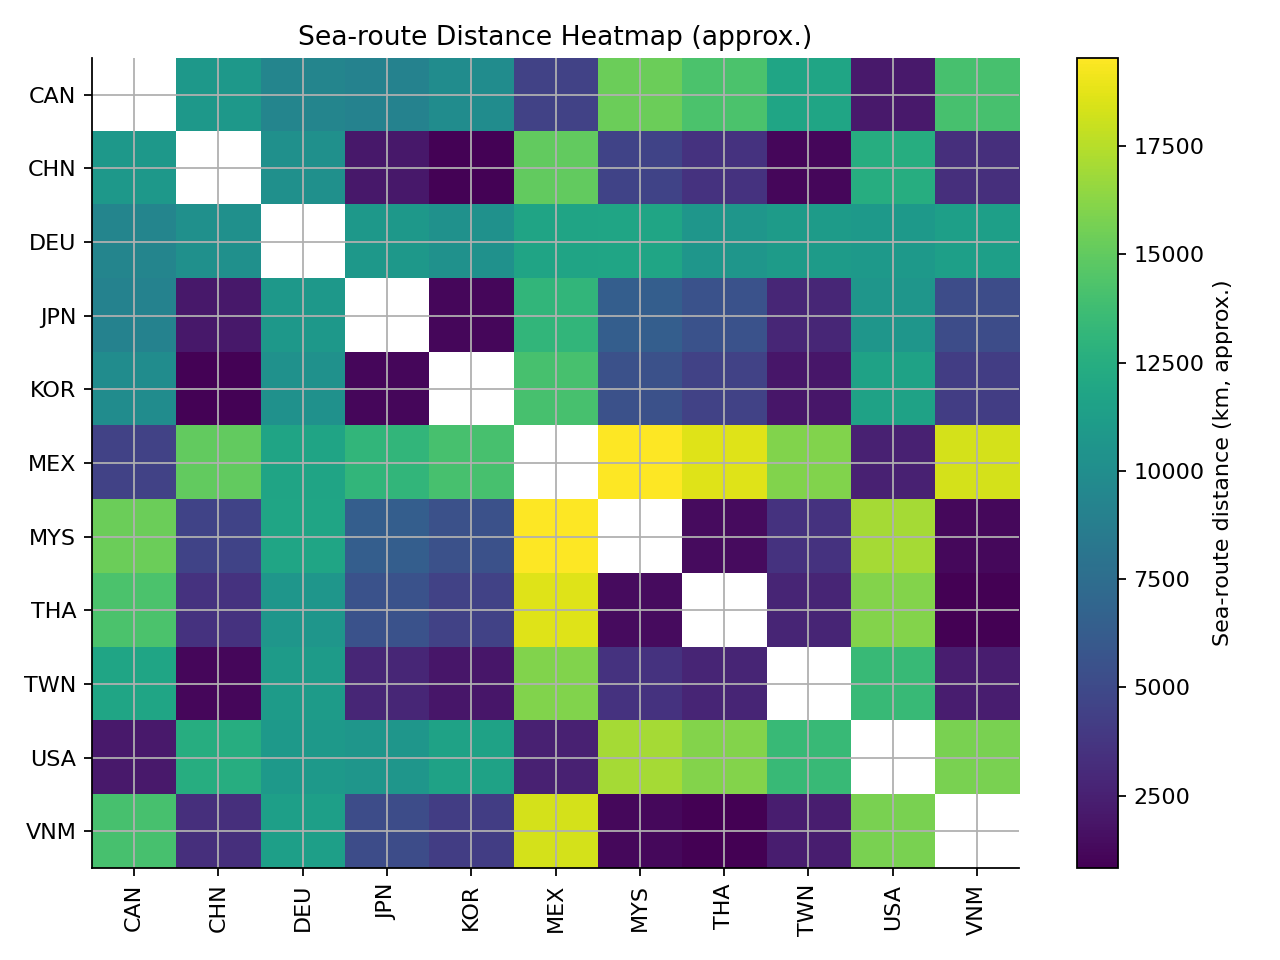


Figure: part4_usa_co2_timeseries.png


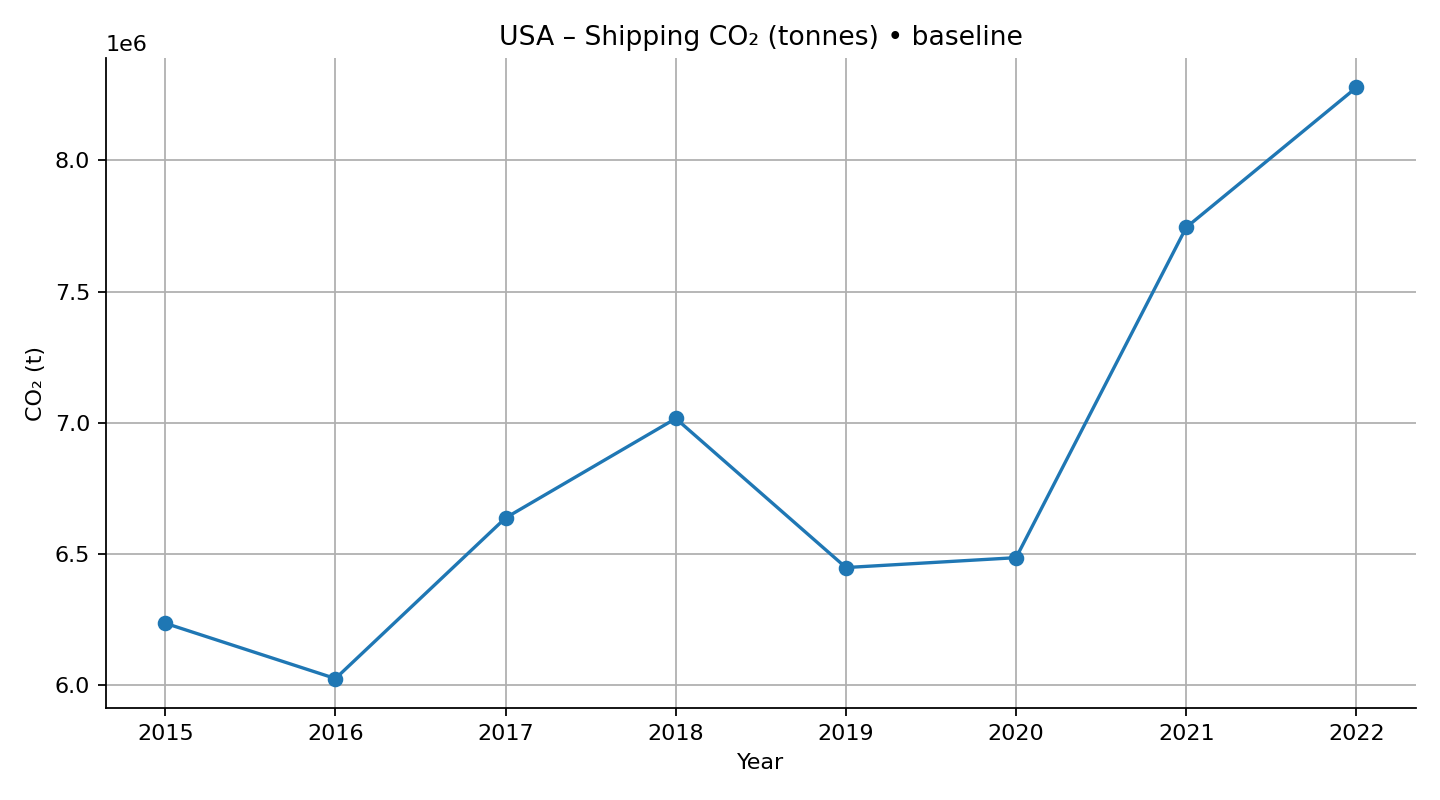


Figure: part4_usa_co2_intensity.png


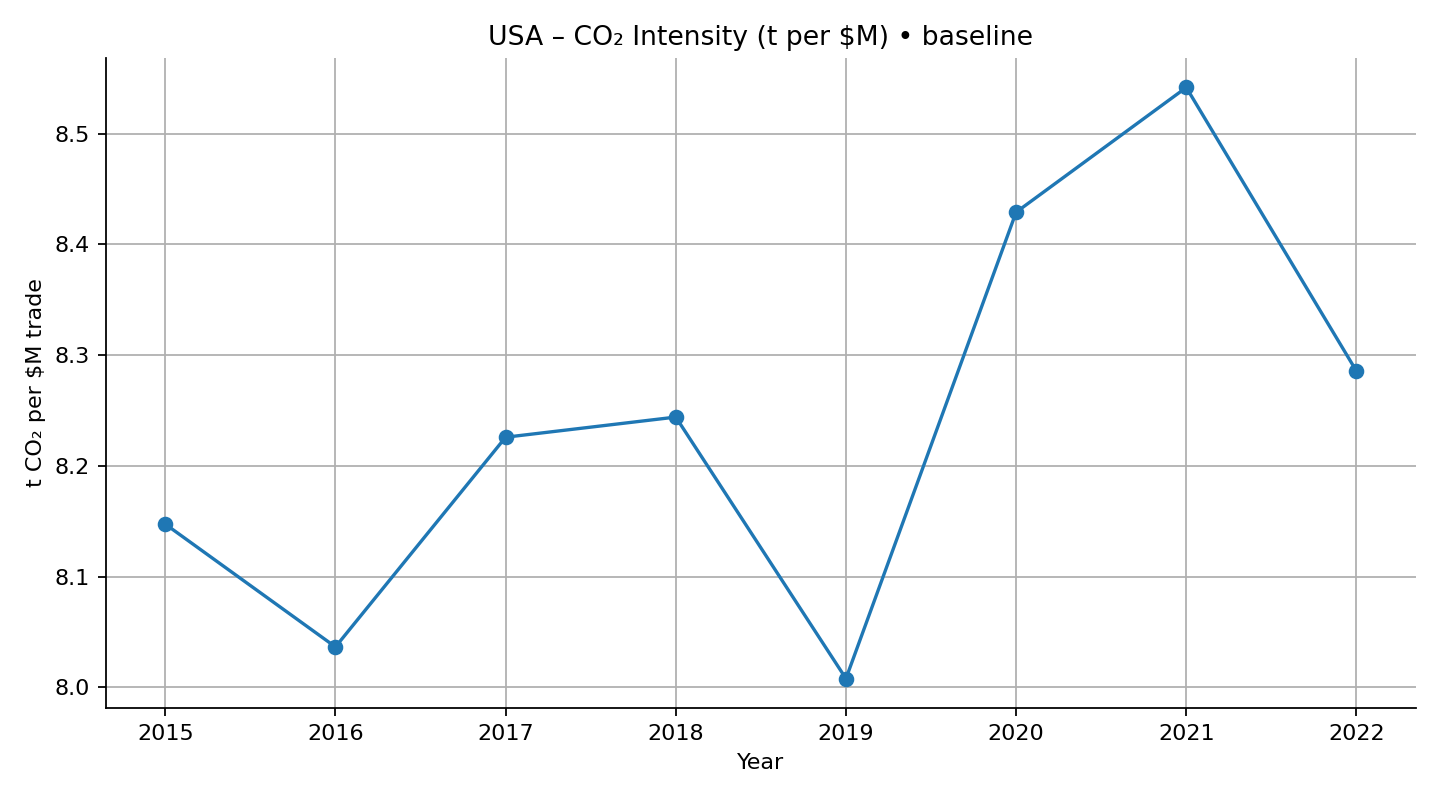


Figure: part4_usa_co2_delta_2017_2022.png


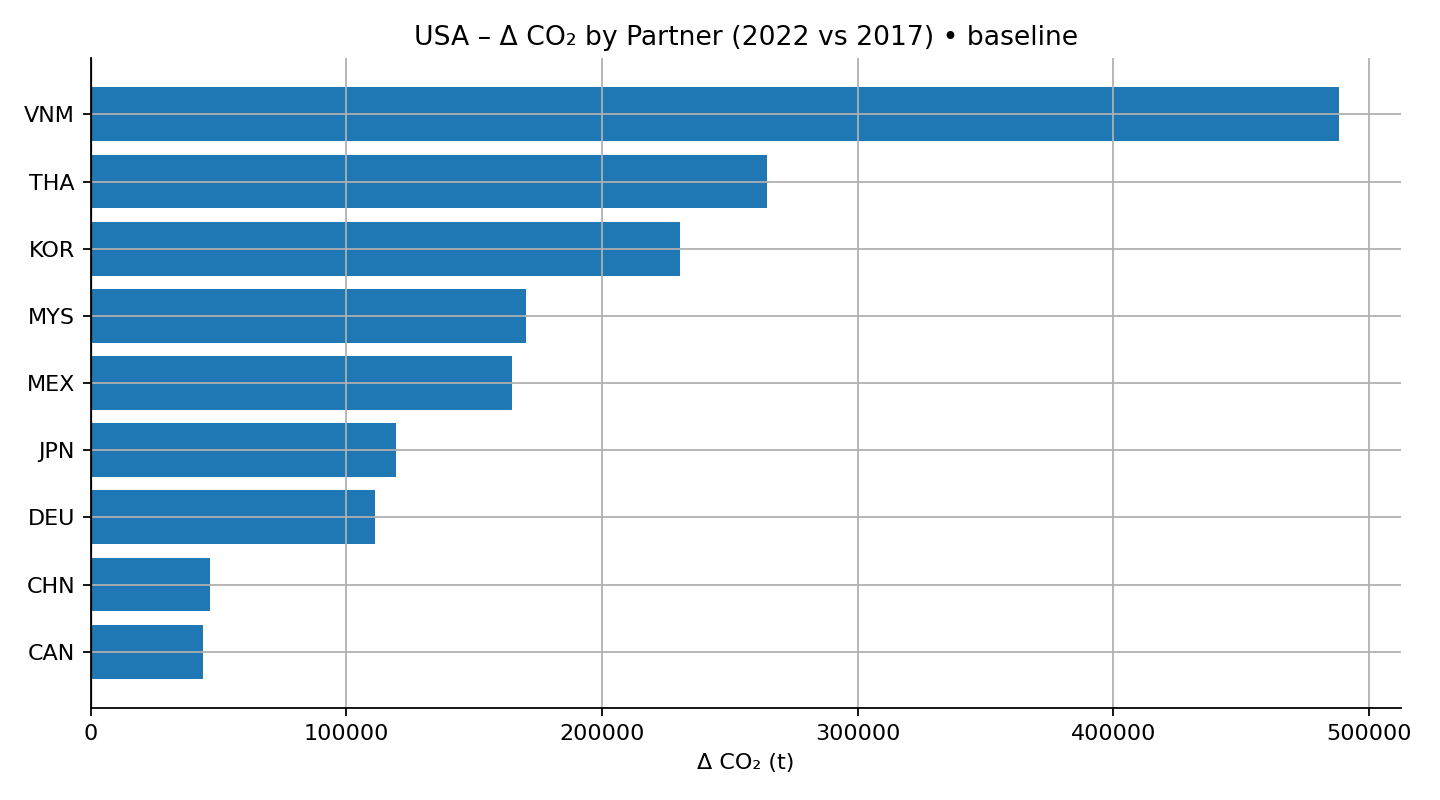


Figure: part4_usa_co2_2017_vs_2022.png


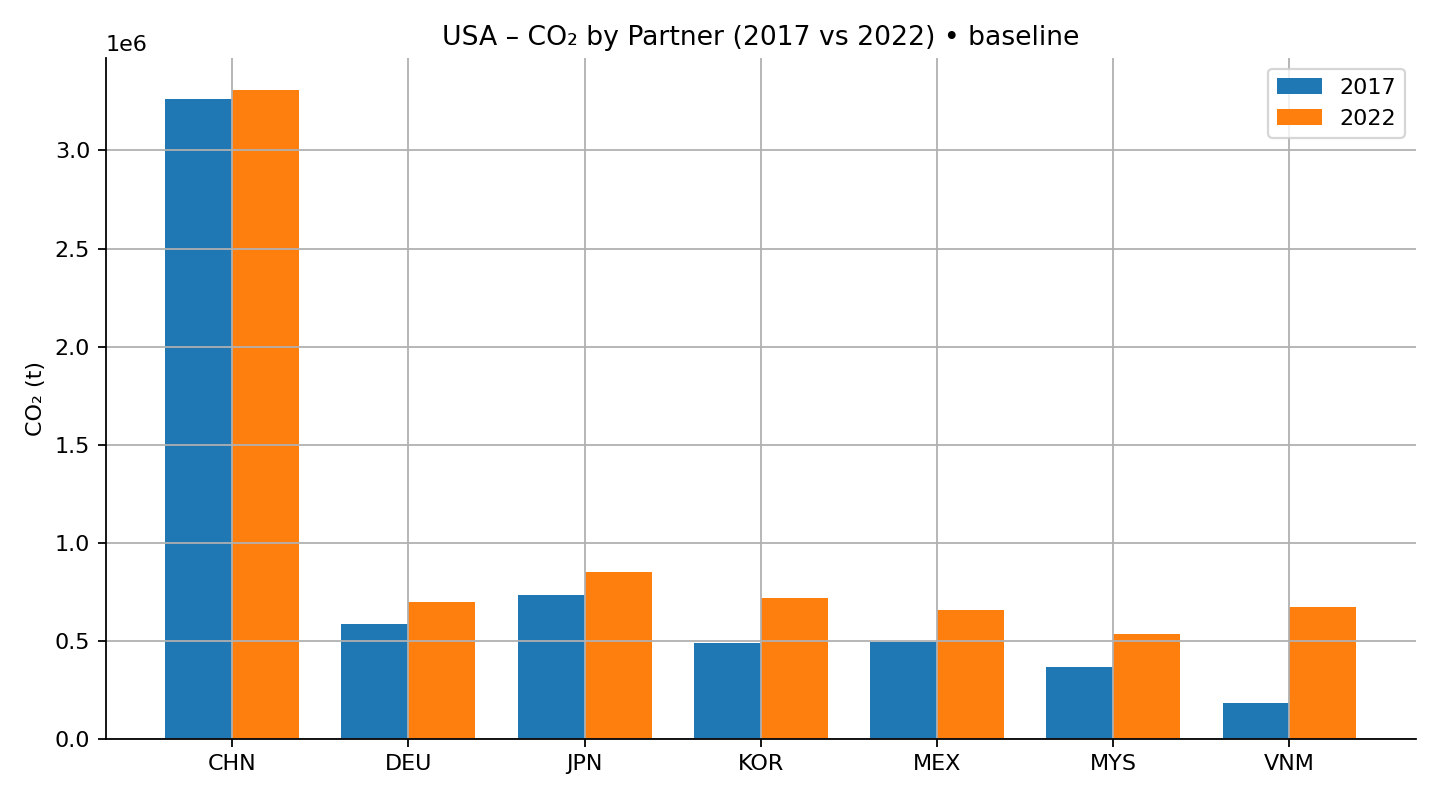


Figure: part4_sensitivity_usa2022.png


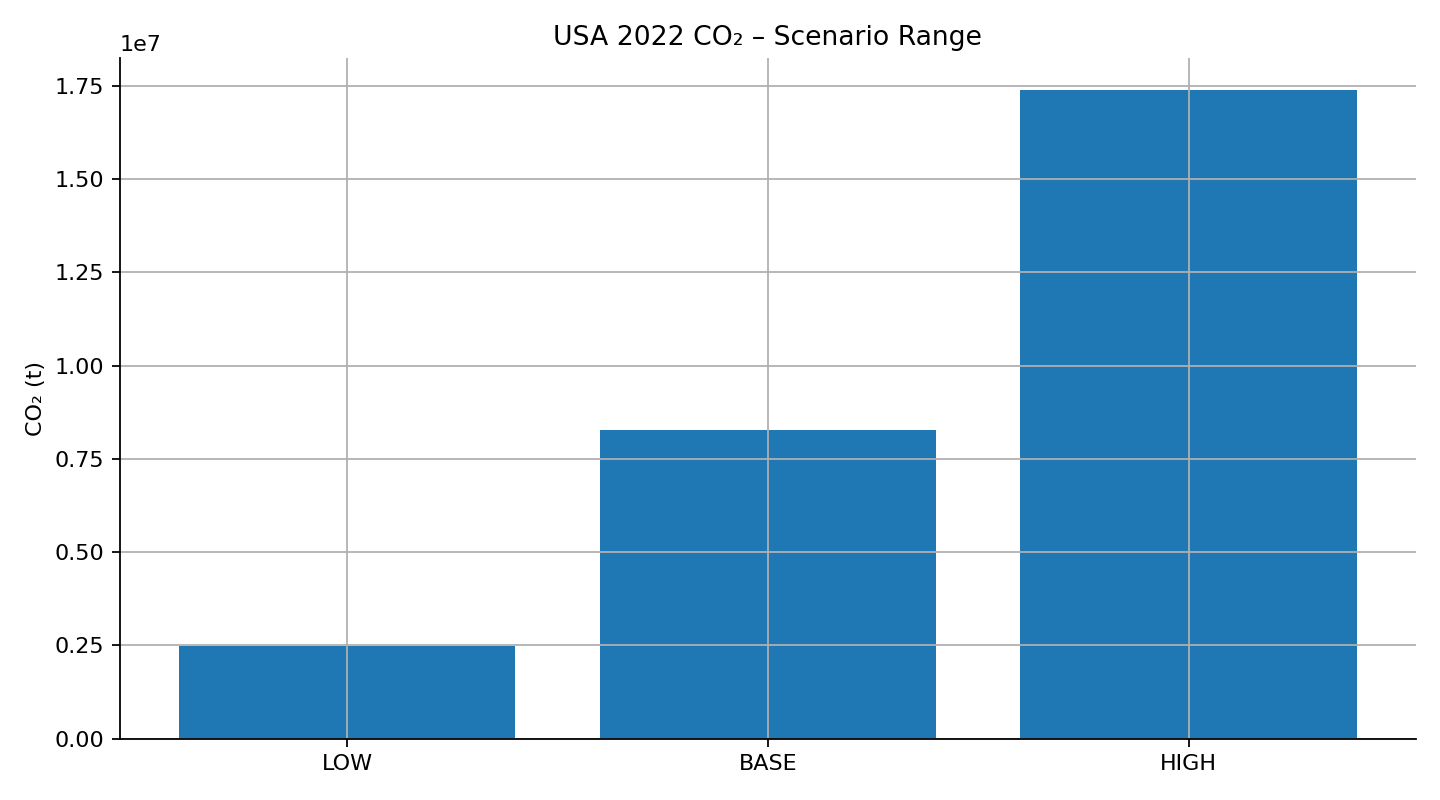

In [38]:
# [7] PUBLISHABLE SUMMARY (TABLES & FIGURES)
# ==========================================

from IPython.display import Image, display

# Tables already saved:
# - part4_distances_gc_sea.csv
# - part4_co2_by_year_reporter.csv
# - part4_co2_by_route_year.csv
# - part4_co2_intensity_by_reporter.csv
# - part4_usa_co2_partner_delta_2017_2022.csv
# - part4_sensitivity_usa_2022.csv

# Display a focused set inline for quick paper assembly:
disp_tables = {
    "CO₂ by Year & Reporter (head)": pd.read_csv(TABLES / "part4_co2_by_year_reporter.csv").head(20),
    "CO₂ Intensity by Reporter (t per $M, head)": pd.read_csv(TABLES / "part4_co2_intensity_by_reporter.csv").head(20),
    "USA Δ CO₂ by Partner (2022–2017)": pd.read_csv(TABLES / "part4_usa_co2_partner_delta_2017_2022.csv").sort_values("delta"),
    "Scenario – USA 2022": pd.read_csv(TABLES / "part4_sensitivity_usa_2022.csv")
}

for title, df in disp_tables.items():
    print("\n" + title)
    display(df)

# And show the recommended figures:
for fn in [
    "part4_distance_heatmap.png",
    "part4_usa_co2_timeseries.png",
    "part4_usa_co2_intensity.png",
    "part4_usa_co2_delta_2017_2022.png",
    "part4_usa_co2_2017_vs_2022.png",
    "part4_sensitivity_usa2022.png",
]:
    path = FIGURES / fn
    if path.exists():
        print("\nFigure:", fn)
        display(Image(filename=str(path)))
    else:
        print("Missing figure:", fn)